# Предсказание победы в Dota 2: Руководство по решению


### Быстрый старт

Берем подготовленные организаторами таблицы с признаками, обучаем модель и отправляем предсказания в систему (как на он-лайн туре) — изи.

1. [Описание данных](#Описание-данных)
2. [Таблицы с признаками от организаторов](#Таблицы-с-признаками-от-организаторов)
3. [Построение модели и оценка качества](#Построение-модели-и-оценка-качества)
4. [Подготовка решения](#Подготовка-решения)

### Работаем как крутые аналитики данных

5. [Кросс валидация: более надежная оценка качества](#Кросс-валидация:-более-надежная-оценка-качества)
6. [Работа с полными описаниями матчей](#Работа-с-полными-описаниями-матчей)
7. [Добавление новых признаков](#Добавление-новых-признаков)
8. [Как построить таблицу признаков с нуля](#Как-построить-таблицу-признаков-с-нуля)

## Описание данных

Архив с данными содержит следующие файлы:

- `sample_submission.csv`: пример файла с решением
- `train_matches.jsonl`, `test_matches.jsonl`: полные описания матчей ("сырые" данные)
- `train_features.csv`, `test_features.csv`: таблицы с признаками от организаторов 
- `train_targets.csv`: таблица с исходами матчей из обучающей выборки, в частности указание победителя

## Таблицы с признаками от организаторов

Таблицы с признаками были подготовлены организаторами, в них каждый матч описывается его базовыми параметрами, для каждого игрока приведен набор статистик на момент остановки матча. О том как подготовить такую таблицу из сырых данных — смотрите далее. 

In [200]:
import pandas

In [201]:
df_train_features = pandas.read_csv('data_final/train_features.csv', index_col='match_id_hash')
df_train_targets = pandas.read_csv('data_final/train_targets.csv', index_col='match_id_hash')

В таблице признаков есть колонка-индекс `match_id_hash` (идентификатор матча) и 245 колонок с признаками. Всего примеров матчей в обучающей выборке — почти 40 тысяч. Самый первый признак `game_time` — время когда матч был остановлен (в секундах). 

In [5]:
# размер таблицы
df_train_features.shape

(39675, 245)

In [6]:
# посмотреть кусочек таблицы
df_train_features.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                      ...        d5_stuns  d5_creeps_stacked  \
match_id_hash                         ...                                      
a400b8f29dece5f4d266f49f1ae2e98a      ...        0.000000                  0   
b9c57c450ce74a2af79c9ce96fac144d      ...        0.000000                  0   
6db558535151ea18ca70a6892197db41      ...        0.000000                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682      ...        8.664527                  3   
b1b35ff97723d9b7ade1c9c3cf48f770      ...        0.000000                  2   

                                  d5_camps_stacked  d5_rune_pickups  \
match_id_hash                                                         
a400b8f29dece5f4d266f49f1ae2e98a                 0                0   
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 1                3   
b1b35ff97723d9b7ade1c9c3cf48f770                 1                2   

                                  d5_firstblood_claimed  \
match_id_hash                                             
a400b8f29dece5f4d266f49f1ae2e98a                      0   
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                      0   

                                  d5_teamfight_participation  \
match_id_hash                                                  
a400b8f29dece5f4d266f49f1ae2e98a                        0.00   
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
46a0ddce8f7ed2a8d9bd5edcbb925682                        0.00   
b1b35ff97723d9b7ade1c9c3cf48f770                        0.25   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a                 0                  0   
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                  0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                  0   

                             

Таблица `train_targets.csv` содержит информацию "из будущего" — то что неизвестно на момент, когда часы показывают `game_time`. Нас будет интересовать колонка `radiant_win` — в ней записано, победит команда Radiant или нет — это целевое событие, вероятность кооторого нужно оценивать. Для тестовой выборки такой информации нет.

In [7]:
df_train_targets.head()

game_time  radiant_win  duration  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155        False       992   
b9c57c450ce74a2af79c9ce96fac144d        658         True      1154   
6db558535151ea18ca70a6892197db41         21         True      1503   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         True      1952   
b1b35ff97723d9b7ade1c9c3cf48f770        453        False      2001   

                                  time_remaining next_roshan_team  
match_id_hash                                                      
a400b8f29dece5f4d266f49f1ae2e98a             837              NaN  
b9c57c450ce74a2af79c9ce96fac144d             496              NaN  
6db558535151ea18ca70a6892197db41            1482          Radiant  
46a0ddce8f7ed2a8d9bd5edcbb925682            1376              NaN  
b1b35ff97723d9b7ade1c9c3cf48f770            1548              NaN

## Построение модели и оценка качества

#### Построим числовую матрицу объект-признак `X` и вектор ответов `y`

In [6]:
X = df_train_features.values
y = df_train_targets['radiant_win'].values

#### Простой способ оценки качества: выделить контрольную подвыборку (validation)

При помощи функции [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбиваем размеченную обучающую выборку на две — 1) новая обучающая `X_train` и 2) контрольная (валидационная) `X_valid`. В качестве параметра функции передается желаемый размер валидационной подвыборки (в нашем случае это 0.3, что означает 30% от размера). Для того чтобы при разных запусках получать одно и то же разбиение, необходимо указать параметр `random_state` — число, которым инициализируется генератор случайных чисел.

In [2]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

#### Обучаем  модель

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Строим предсказания на валидационной выборке

У моделей классификации в SciKit-Learn метод `model.predict(X)` дает вектор с точными предсказаниями (например: 0 или 1). Большинство алгоритмов классификации имеют дополнительный метод — `model.predict_proba(X)`, который оценивает вероятность каждого класса и возвращает матрицу, в которой строчка соответствует объекту, а столбец — классу. Нас интересует вероятность победы Radiant, т.е. вероятность первого класса, поэтому возьмем у матрицы колонку с индексом `1`:

In [25]:
y_pred = model.predict_proba(X_valid)[:, 1]

Получаем вот такие предсказания на валидационной выборке:

In [26]:
y_pred

array([0.64, 0.6 , 0.4 , ..., 0.51, 0.45, 0.25])

#### Оценим качество предсказаний на валидационной выборке

Посчитаем на валидационных примерах метрику ROC-AUC.

In [50]:
from sklearn.metrics import roc_auc_score

In [27]:
valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7758601049138184


Можем для интереса посчитать долю правильных ответов для классификатора, который принимает решение 1 если вероятность больше 50%

In [5]:
from sklearn.metrics import accuracy_score

In [ ]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', valid_accuracy)

## Подготовка решения

Воспользуемся обученной выше моделью, предскажем вероятность победы Radiant для всех тестовых примеров.

In [16]:
df_test_features = pandas.read_csv('data_final/test_features.csv', index_col='match_id_hash')

X_test = df_test_features.values
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pandas.DataFrame({'radiant_win_prob': y_test_pred}, index=df_test_features.index)

In [17]:
df_submission.head()

radiant_win_prob
match_id_hash                                     
30cc2d778dca82f2edb568ce9b585caa              0.50
70e5ba30f367cea48793b9003fab9d38              0.86
4d9ef74d3a2025d79e9423105fd73d41              0.77
2bb79e0c1eaac1608e5a09c8e0c6a555              0.61
bec17f099b01d67edc82dfb5ce735a43              0.47

Сохраняем предсказания в файл, их можно отправлять в систему. Для удобства в названии файла указываем дату и время.

In [18]:
import datetime
submission_filename = 'submission_{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2018-05-03_19:30:46.csv


## Кросс-валидация: более надежная оценка качества

Кросс-валидация — это продвинутый способ оценить качество модели на обучающей выборке. В любом разбиении на обучение и контроль есть случайность — из-за этой случайности оценка качества может оказаться завышенной или наоборот — заниженной, это может привести к тому что участник выберет не самую лучшую модель и на лидерборде получит не самый лучший результат.

Давайте сделаем много случайных разбиений на обучение/валидацию и проверим качество на каждом.

Для этого в SciKit-Learn есть модуль [`model_selection`](http://scikit-learn.org/stable/modules/cross_validation.html). В нем есть удобная функция [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) позволяющая считать качество модели на наборе разбиений. Также в модуле есть различные генераторы разбиений, например:

- [`ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) — генерирует заданное число случайных разбиений в заданном соотношении,
- [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) — генерирует разбиения по специальной схеме при которой каждый объект попадает в валидационную подвыборку ровно один раз.

#### Создаем разбиение исходной обучающей выборки `X`

In [9]:
from sklearn.model_selection import ShuffleSplit, KFold

In [13]:
# Создаем 5 разбиений в соотношении — обучение 70% / валидация 30%
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=123)

In [485]:
from sklearn.model_selection import cross_val_score

#### Запускаем кросс-валидацию

Оценим качество алгоритма `RandomForestClassifier` с разными параметрами — в первом случае будем строить полное дерево, во втором случае — ограничивать по высоте, так чтобы в листьях было хотя бы 3 примера.

Кросс-валидация требует обучать модель много раз подряд, поэтому этот процесс может занимать значительное время. Время хакатона ограничено. Поэтому для ускорения рекомендуется следующее:

- делайте небольшое число разбиений (будет работать быстрее, но оценка будет менее надежная)
- используйте сразу все процессоры вашего компьютера и распараллеливайте, указывая параметр `n_jobs`

In [24]:
%%time

model_rf1 = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)

# вычисляем ROC-AUC на всех построенных разбиениях cv
cv_scores_rf1 = cross_val_score(model_rf1, X, y, cv=cv, scoring='roc_auc')

CPU times: user 2min 44s, sys: 44.3 s, total: 3min 28s
Wall time: 50.4 s


In [25]:
%%time

model_rf2 = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, random_state=42, n_jobs=-1)

# оценка качества на разных разбиениях может делаться параллельно на разных процессорах
# для того чтобы включить паралелльность нужно указать n_jobs=<число процессоров>, -1 — автоматический подбор
cv_scores_rf2 = cross_val_score(model_rf2, X, y, cv=cv, scoring='roc_auc')

CPU times: user 2min 30s, sys: 41.8 s, total: 3min 12s
Wall time: 46.3 s


#### Смотрим на результаты кросс-валидации

Результат работы `cross_val_score` — массив с подсчитаным ROC-AUC по всем разбиениям. Посмотрим на них:

In [26]:
cv_scores_rf1

array([0.78369011, 0.77511895, 0.77475305, 0.77617993, 0.7790677 ])

In [27]:
cv_scores_rf2

array([0.7860283 , 0.77848456, 0.78023537, 0.77829623, 0.77878618])

Посчитаем средний ROC-AUC для всех разбийний и сравним:

In [28]:
print('Model 1 mean score:', cv_scores_rf1.mean())
print('Model 2 mean score:', cv_scores_rf2.mean())

Model 1 mean score: 0.7777619467898124
Model 2 mean score: 0.7803661269215967


Вторая модель имеет в среднем лучший результат. Это значит, что лучше взять именно ее. Но, обратите внимание: только на 4х из 5 разбиений мы выявили лучшее качество. Если бы мы использовали одно разбиение, то с вероятностью 1:5 мы сделали бы вывод о том, что вторая модель работает хуже.

In [29]:
cv_scores_rf2 > cv_scores_rf1

array([ True,  True,  True,  True, False])

## Работа с полными описаниями матчей

Полные описания матчей ("сырые" данные) представлены в файлах `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит по одной строчке на матч — в строчке записан объект, закодированный в формате [JSON](https://en.wikipedia.org/wiki/JSON). Про JSON достаточно знать лишь то, что его можно лего переводить в Python-объекты (словари, спики, числа, строки и тд) при помощи функции `json.loads`.

##### Посмотрим на одну строчку из файла

In [13]:
import json

In [49]:
with open('data_final/train_matches.jsonl') as fin:
    # Прочитаем 18-ю строчку из файла
    for i in range(18):
        line = fin.readline()
    
    # расшифруем формат JSON в обычный Python-объект
    match = json.loads(line)

Обект `match` — это большой словарь, в полях которого есть значения и другие вложенные словари. В частности есть массив `match['players']` в котором записано описание каждого игрока.

Объект `match` — это и есть те данные, в том виде, в котором они встречаются в реальной жизни, на практике. Подробное описание полей есть в руководстве по задаче. Помните, что настоящий специалист по анализу данных может не вдаваться глубоко в предметную область (в данном контексте это означает что можно практически ничего не знать про игру Dota 2), для того чтобы найти сложную закономерность в данных; в этом искусство и сила специалистов по Data Science.

In [34]:
#match

#### Объекты с описанием игроков

In [32]:
player = match['players'][2]

KDA: число убийств, смертей и помощи союзникам

In [35]:
player['kills'], player['deaths'], player['assists']

(8, 11, 12)

Статистика по использованию умений игрока:

In [36]:
player['ability_uses']

{'kunkka_ghostship': 16,
 'kunkka_return': 1,
 'kunkka_torrent': 43,
 'kunkka_x_marks_the_spot': 8}

#### Пример: временной ряд изменения золота во всем игрокам

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Text(0.5,1,'Gold change for all players')

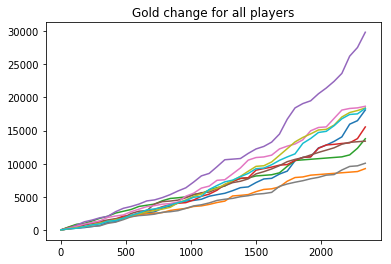

In [38]:
for player in match['players']:
    plot(player['times'], player['gold_t'])
    
title('Gold change for all players')

#### Функция для чтения файла с матчами

Далее приведена функция `read_matches(filename)`, которую можно использовать для чтения объектов из файлов с сырыми данными.

Рекомендуется установить два Python пакета: `ujson` и `tqdm`, без них чтение будет работать дольше и не будет прогресс-бара.

In [1]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Установите пакет ujson для того чтобы декодировать JSON-объекты быстрее')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Установите пакет tqdm для того чтобы видеть прогресс и оценку времени завершения')

In [4]:
def read_matches(matches_file):
    
    # Число матчей, нужно того чтобы видеть Progress Bar и оценку времени завершения
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

#### Чтение матчей в цикле

Чтение всех матчей может занять 2-3 минуты. Поэтому очень важно во время хакатона следовать следующему алгоритму:

1. Прочитайте небольшое число матчей (10-100)
2. Напишите код, который извлекает из матча нужные признаки или считает нужную статистику
3. Убедитесь что код работает без ошибок
4. Запустите полный прогон вашего алгоритма по всем матчам
5. Сохраните результат в CSV-таблицу или при помощи `pickle`, для того чтобы его не пришлось вычислять заново

In [42]:
for match in read_matches('data_final/train_matches.jsonl'):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    # обработка матча
    
    for player in match['players']:
        pass  # обработка игрока

HBox(children=(IntProgress(value=0, max=39675), HTML(value='')))

## Добавление новых признаков

In [16]:
def add_new_features(df_features, matches_file):
    
    # Пройдем по сырым данным и добавим новые признаки в таблицу
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Подсчет числа разбитых Башен для обеих команд
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Записываем в таблицу значения признаков
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        
        # ... здесь вы можете дописать свои собственные признаки ...
        

In [10]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые признаки
add_new_features(df_train_features_extended, 'data_final/train_matches.jsonl')

HBox(children=(IntProgress(value=0, max=39675), HTML(value='')))

В последних колонках видим новые признаки

In [49]:
df_train_features_extended.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                        ...         d5_rune_pickups  \
match_id_hash                           ...                           
a400b8f29dece5f4d266f49f1ae2e98a        ...                       0   
b9c57c450ce74a2af79c9ce96fac144d        ...                       0   
6db558535151ea18ca70a6892197db41        ...                       0   
46a0ddce8f7ed2a8d9bd5edcbb925682        ...                       3   
b1b35ff97723d9b7ade1c9c3cf48f770        ...                       2   

                                  d5_firstblood_claimed  \
match_id_hash                                             
a400b8f29dece5f4d266f49f1ae2e98a                      0   
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                      0   

                                  d5_teamfight_participation  \
match_id_hash                                                  
a400b8f29dece5f4d266f49f1ae2e98a                        0.00   
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
46a0ddce8f7ed2a8d9bd5edcbb925682                        0.00   
b1b35ff97723d9b7ade1c9c3cf48f770                        0.25   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a                 0                  0   
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                  0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                  0   

                                  d5_obs_placed  d5_sen_placed  \
match_id_hash                                                    
a400b8f29dece5f4d266f49f1ae2e98a              0              0   
b9c57c450ce74a2af79c9ce96fac144d              0              0   
6db558535151ea18ca70a6892197db41              0              0   
46a0ddce8f7ed2a8d9bd5edcbb925682              2              0   
b1b35ff97723d9b7ade1c9c3cf48f770              0              0   

                                  radiant_tower_kills  dire_tower_kills  \
match_id_hash                                       

#### Оценка улучшения качества

Запустим кросс-валидацию и сравним одну и ту же модель на разных признаковых описаниях: 1) от организаторов (base) 2) с добавлением тех что мы только что построили (extended)

In [50]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

cv_scores_base = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_extended = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring='roc_auc', n_jobs=-1)

CPU times: user 2.03 s, sys: 4.2 s, total: 6.23 s
Wall time: 21.8 s


In [51]:
print('Base features: mean={} scores={}'.format(cv_scores_base.mean(), cv_scores_base))
print('Extended features: mean={} scores={}'.format(cv_scores_extended.mean(), cv_scores_extended))

Base features: mean=0.7128933102889562 scores=[0.7131916  0.70902319 0.71416197 0.71504327 0.71304652]
Extended features: mean=0.7292038457525152 scores=[0.72860431 0.72630564 0.72536915 0.73350007 0.73224005]


In [52]:
cv_scores_extended > cv_scores_base

array([ True,  True,  True,  True,  True])

#### Подготовка решения

In [53]:
# Добавим те же признаки в тестовую выборку
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 'data_final/test_matches.jsonl')

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [54]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X, y)
df_submission_base = pandas.DataFrame(
    {'radiant_win_pred': model.predict_proba(df_test_features.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_base.to_csv('submission_base_rf.csv')

In [55]:
model_extended = RandomForestClassifier(n_jobs=-1)
model_extended.fit(df_train_features_extended.values, y)
df_submission_extended = pandas.DataFrame(
    {'radiant_win_pred': model_extended.predict_proba(df_test_features_extended.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_extended.to_csv('submission_extended_rf.csv')

## Как построить таблицу признаков с нуля

Ниже приведен код, которым организаторы построили таблицы `train_features.csv` и `test_features.csv`. Вы можете модифицировать этот код, менять и добавлять свои признаки.

In [12]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [3]:
def make_roshan_target(x):
    if isinstance(x, float) and math.isnan(x):
        return 0
    elif x == 'Radiant':
        return 1
    else:
        return 2

In [4]:
def cross_val_score_roshan(model, df_train_features, df_train_targets, cv=5, use_nans=False):
    X = df_train_features.values
    y = df_train_targets['next_roshan_team'].map(make_roshan_target).values
    if use_nans:
        for main_class in range(3):
            X_copy = X.copy()
            y_copy = y.copy()
            args, *_ = np.where(y_copy == main_class)
            y_copy.fill(0)
            y_copy[args] = 1
            cross_val = cross_val_score(rf_roshan, X_copy, y_copy, cv=cv, scoring='roc_auc')
            print('Main class #{}: {}'.format(main_class, cross_val))
    else:
        args, *_ = np.where(y != 0)
        X = X[args]
        y = y[args]
        y[y == 2] = 0
        cross_val = cross_val_score(rf_roshan, X, y, cv=cv, scoring='roc_auc')
        print('Radiant: {}'.format(cross_val))

In [9]:
rf_roshan = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [112]:
cross_val_score_roshan(rf_roshan, df_train_features, df_train_targets)

Radiant: [0.6867186  0.68347818 0.68926904 0.68729533 0.68573436]


In [15]:
cross_val_score_roshan(rf_roshan, df_train_features, df_train_targets, use_nans=True)

Main class #0: [0.67122096 0.66584767 0.65797252 0.65720687 0.67346905]
Main class #1: [0.64453208 0.64263785 0.63075366 0.63515632 0.62876916]
Main class #2: [0.65156772 0.64954332 0.64806762 0.64222576 0.65537448]


In [100]:
with open('data/train_matches.jsonlines') as fin:
    # Прочитаем 18-ю строчку из файла
    for i in range(18):
        line = fin.readline()
    
    # расшифруем формат JSON в обычный Python-объект
    match = json.loads(line)

In [22]:
match['players'][0].keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

# Начинаем сеточки отсюда

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import pandas as pd
import numpy as np
import math
from collections import OrderedDict

import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Установите пакет ujson для того чтобы декодировать JSON-объекты быстрее')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Установите пакет tqdm для того чтобы видеть прогресс и оценку времени завершения')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import Sampler, BatchSampler, SubsetRandomSampler, SequentialSampler
from tqdm import tqdm_notebook

In [4]:
MATCHES_COUNT = {}
num_lines = !wc -l data*/*
for response in num_lines:
    response = response.strip()
    num, filepath = response.split(' ')
    num = int(num)
    _, filename = os.path.split(filepath)
    *_, ext = filename.split('.')
    if ext.startswith('json'):
        MATCHES_COUNT[filepath] = num

In [5]:
def read_matches(matches_file):
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=MATCHES_COUNT.get(matches_file)):
            match = json.loads(line)
            if len(match['players'][0]['times']) > 0:
                yield match

In [6]:
def make_time_series_features_from_file(filename):
    times = []
    t_keys = ('gold_t', 'lh_t', 'dn_t', 'xp_t')
    features = {t_key: [] for t_key in t_keys}
    
    for i, match in enumerate(read_matches(filename)):
        for t_key in t_keys:
            for player in match['players']:
                if len(features[t_key]) == i:
                    if t_key == t_keys[0]:
                        times.append(len(player['times']))
                    features[t_key].append([player[t_key]])
                else:
                    features[t_key][i].append(player[t_key])
            features[t_key][i] = np.vstack(map(lambda x: np.array(x), features[t_key][i]))
    idx_sort = np.argsort(times)[::-1]
    
    for t_key in t_keys:
        new_features = [None] * idx_sort.size
        for i, idx in tqdm_notebook(enumerate(idx_sort)):
            new_features[i] = torch.from_numpy(features[t_key][idx]).type(torch.float32).transpose_(0, 1)
        features[t_key] = nn.utils.rnn.pad_sequence(new_features, batch_first=True, padding_value=-1)
        
    features_ = torch.cat(tuple(features.values()), dim=-1)
    features = torch.zeros_like(features_)
    
    for sorted_idx, original_idx in enumerate(idx_sort):
        features[original_idx] = features_[sorted_idx]
    
    return features

In [7]:
features = make_features_and_targets_from_file('data/train_matches.jsonlines')

HBox(children=(IntProgress(value=0, max=10801), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [7]:
class GlobalAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return torch.mean(x, self.dim)

In [8]:
class TimeSeriesPredictor(nn.Module):
    """
    This class gets time series and predicts the target value
    """
    
    def __init__(self, in_size=40, mode='conv', n_classes=1, dropout_rate=0.5):
        super(self.__class__, self).__init__()
        
        self.mode = mode
        self.pool = GlobalAvgPooling()
        self.activation = nn.LeakyReLU(inplace=True)
        self.n_classes = n_classes
        
        if mode == 'conv':
            self.dropout = nn.Dropout(p=dropout_rate, inplace=True)
            self.conv = nn.Sequential(
                nn.Conv1d(in_size, 32, kernel_size=3, padding=1),
                nn.AvgPool1d(kernel_size=3),
                nn.BatchNorm1d(32),
                self.dropout,
                self.activation,
                nn.Conv1d(32, 16, kernel_size=3, padding=1),
                nn.AvgPool1d(kernel_size=3),
                nn.BatchNorm1d(16),
                self.dropout,
                self.activation,
                nn.Conv1d(16, 4, kernel_size=2, padding=1),
                self.pool,
                nn.BatchNorm1d(4),
                self.dropout,
                self.activation,
                nn.Linear(4, self.n_classes)
            )
        elif self.mode == 'lstm':
            self.lstm = nn.LSTM(in_size, 16, batch_first=True, num_layers=3, dropout=dropout_rate)
            self.dense = nn.Linear(16, self.n_classes)
            
        self.reset_parameters()
        
    def forward(self, x):
        if self.mode == 'conv':
            h = torch.transpose(x, 1, 2)
            out = self.conv(h)
        elif self.mode == 'lstm':
            self.lstm.flatten_parameters()
            h, _ = self.lstm(x)
            h = torch.transpose(h, 1, 2)
            h = self.pool(h)
            self.activation(h)
            out = self.dense(h)
            
        if self.n_classes == 1:
            out = out[:, 0]

        return out
    
    def reset_parameters(self):
        for param in self.parameters():
            if isinstance(param, (nn.Conv1d, nn.Linear, nn.BatchNorm1d)):
                nn.init.xavier_normal_(self.weight)
                nn.init.constant_(self.bias, 0)
            elif isinstance(param, nn.LSTM):
                for weight in (param.weight_hh_l0, param.weight_ih_l0):
                    nn.init.xavier_normal_(weight)
                for bias in (param.bias_hh_l0, param.bias_ih_l0):
                    nn.init.constant_(bias, 0)

In [9]:
def train_val_split(dataset, val_size=0.2, train_batch_size=32, val_batch_size=32,
                    shuffle=True, num_workers=4, random_seed=0):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    split = int(np.floor(val_size * num_samples))
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(dataset, batch_size=val_batch_size, sampler=val_sampler, num_workers=num_workers)
    
    return train_loader, val_loader

In [10]:
class SubsetSequentialSampler(Sampler):
    r"""Samples elements sequentially from a given list of indices, always in the same order.

    Arguments:
        indices (list): a list of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [11]:
def cross_val(dataset, cv=5, train_batch_size=32, val_batch_size=32, shuffle=True, num_workers=4, random_seed=0):
    assert cv > 1, "Number of cross-val splits should be greater than 1"
    
    num_samples = len(dataset)
    indices = np.arange(num_samples)
    cv_block_size = int(np.ceil(num_samples / cv))
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    for cv_split in range(cv):
        val_begin = cv_block_size * cv_split
        val_end = min(cv_block_size * (cv_split + 1), num_samples)
        val_idx = np.arange(val_begin, val_end)
        train_idx = []
        if cv_split > 0:
            train_idx.append(np.arange(0, val_begin))
        if cv_split + 1 < cv:
            train_idx.append(np.arange(val_end, num_samples))
        train_idx = np.concatenate(train_idx)
        
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetSequentialSampler(val_idx)

        train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=train_batch_size,
                                  drop_last=False, num_workers=num_workers)
        val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=val_batch_size,
                                drop_last=False, num_workers=num_workers)
        
        yield train_loader, val_loader

In [14]:
train_loader, val_loader = train_val_split(features, targets, train_batch_size=256, val_batch_size=256)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from callbacks import BaseHistoryPlotter, BaseLogger, BasePrinter, Callback, CallbackList, EarlyStopping

In [14]:
def binary_cross_entropy_with_logits(input, target):
    return F.binary_cross_entropy_with_logits(input, target, size_average=False)

In [15]:
def train_loop(model, opt, loss_function, num_epochs, train_loader, val_loader, callbacks, device):
    for epoch_i in range(num_epochs):
        if hasattr(model, 'stop_training') and model.stop_training:
            break

        model.train()
        callbacks.on_epoch_begin(epoch_i)
        print("Training:")

        for batch_i, batch in enumerate(tqdm_notebook(iter(train_loader))):
            *batch_features, batch_targets = map(lambda x: x.to(device), batch)    
            batch_size, *_ = batch_targets.shape
            callbacks.on_batch_begin(batch_i, logs={'size': batch_size})

            predictions = model(*batch_features)
            opt.zero_grad()
            loss = loss_function(predictions, batch_targets)
            loss.backward()
            opt.step()

            callbacks.on_batch_end(batch_i, logs={'train_loss': loss.item()})

        model.eval()
        print("Validation:")

        for batch_i, batch in enumerate(tqdm_notebook(iter(val_loader))):
            *batch_features, batch_targets = map(lambda x: x.to(device), batch)      
            batch_size, *_ = batch_targets.shape
            callbacks.on_val_batch_begin(batch_i, logs={'size': batch_size})

            predictions = model(*batch_features)
            loss = loss_function(predictions, batch_targets)

            callbacks.on_val_batch_end(batch_i, logs={'val_loss': loss.item()})

        callbacks.on_epoch_end(epoch_i, logs={})

In [16]:
def train(model, opt, train_loader, val_loader, num_epochs=50, loss_function=binary_cross_entropy_with_logits,
          callbacks=None, device=device):
    model.to(device)
    
    if callbacks is None:
        callbacks = BaseLogger()
    else:
        callbacks = CallbackList(callbacks=callbacks)
        
    callbacks.set_model(model)
    callbacks.on_train_begin()
    
    try:
        train_loop(model, opt, loss_function, num_epochs, train_loader, val_loader, callbacks, device)
            
    except KeyboardInterrupt:
        pass
    
    callbacks.on_train_end()

In [17]:
from copy import deepcopy

In [18]:
def cross_val_predict(model, opt, dataset, cv=5, num_epochs=50,
                      loss_function=binary_cross_entropy_with_logits,
                      train_batch_size=32, val_batch_size=32, callbacks=None, device=device):
    model.to(device)
    initial_model_state = deepcopy(model.state_dict())
    initial_opt_state = deepcopy(opt.state_dict())
        
    if callbacks is None:
        callbacks_ = BaseLogger()
    else:
        callbacks_ = CallbackList(callbacks=callbacks)
    
    try:
        predictions_logits = []
        for train_loader, val_loader in cross_val(dataset, cv=cv, shuffle=False,
                                                  train_batch_size=train_batch_size, val_batch_size=val_batch_size):
            callbacks = deepcopy(callbacks_)
            callbacks.set_model(model)
            callbacks.on_train_begin()
            train_loop(model, opt, loss_function, num_epochs, train_loader, val_loader, callbacks, device)
            callbacks.on_train_end()
            
            model.eval()
            
            with torch.no_grad():
                for batch_i, batch in enumerate(tqdm_notebook(iter(val_loader))):
                    *batch_features, batch_targets = map(lambda x: x.to(device), batch)
                    predictions_logits.append(model(*batch_features).cpu())
                    
            model.load_state_dict(initial_model_state)
            opt.load_state_dict(initial_opt_state)
            
        return torch.cat(predictions_logits)
            
    except KeyboardInterrupt:
        pass

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
def cross_val_score_nn(model, opt, dataset, scoring_function=roc_auc_score, cv=5, num_epochs=50,
                       loss_function=binary_cross_entropy_with_logits,
                       train_batch_size=32, val_batch_size=32, callbacks=None, device=device):
    predictions = cross_val_predict(model, opt, dataset, cv=cv, num_epochs=num_epochs,
                                    loss_function=loss_function, train_batch_size=train_batch_size,
                                    val_batch_size=val_batch_size, callbacks=callbacks, device=device)
    if predictions.ndimension() > 1 and predictions.shape[1] > 1:
        predictions = predictions.argmax(dim=-1)
    *_, targets = dataset.tensors
    targets, predictions = map(lambda x: x.numpy(), (targets, predictions))
    return scoring_function(targets, predictions)

In [21]:
def compute_score(model, val_loader, scoring_function=roc_auc_score, device=device):
    model.to(device)
    model.eval()
    predictions = []
    targets = []
    for batch in iter(val_loader):
        *batch_features, batch_targets = map(lambda x: x.to(device), batch)
        with torch.no_grad():
            prediction = F.sigmoid(model(*batch_features))
            predictions.append(prediction.cpu().numpy())
        targets.append(batch_targets.cpu().numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return scoring_function(targets, predictions)

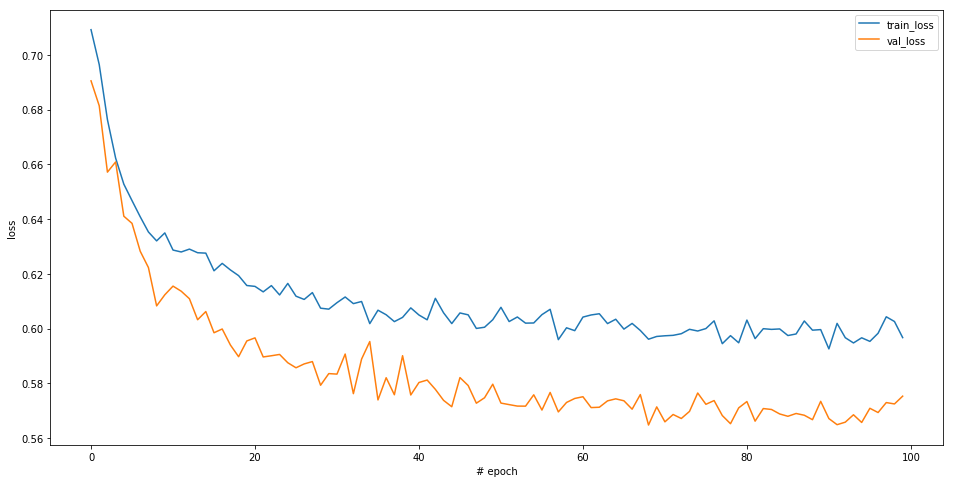

Train loss: 0.597
Val loss: 0.575



In [106]:
model = TimeSeriesPredictor()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter()])

In [107]:
compute_score(model, val_loader)

0.7893450903881527

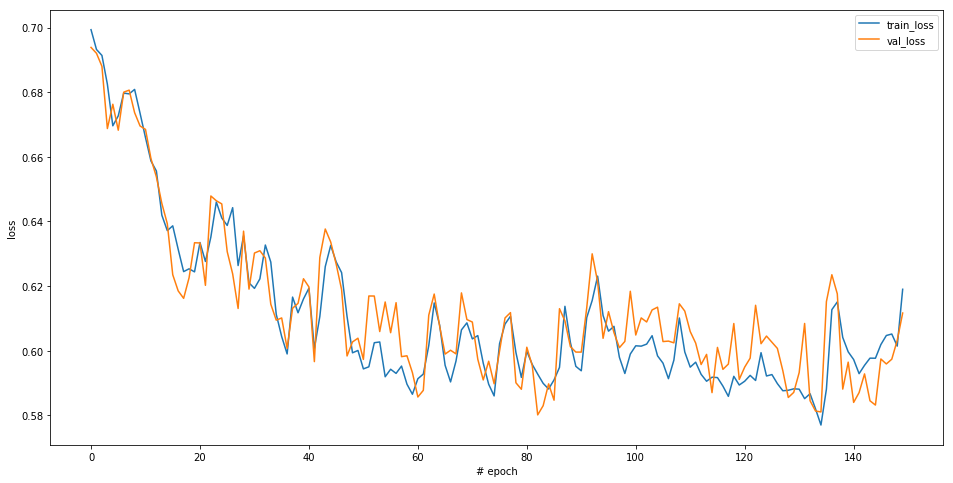

Train loss: 0.619
Val loss: 0.612



In [108]:
model = TimeSeriesPredictor(mode='lstm', dropout_rate=0.7)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=150,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter()])

In [109]:
compute_score(model, val_loader)

0.7215730740212063

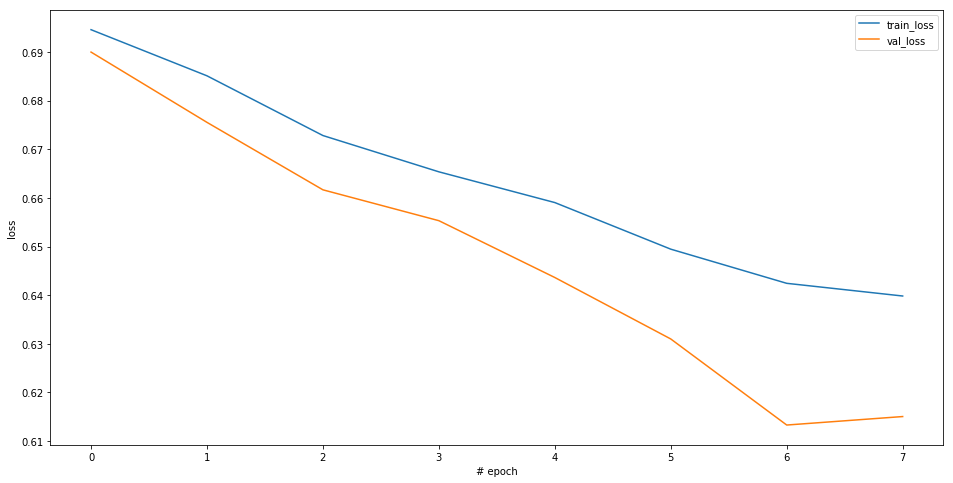

Train loss: 0.640
Val loss: 0.615

Training:


HBox(children=(IntProgress(value=0, max=34), HTML(value='')))


Validation:


In [22]:
try:
    predictions_logits = torch.load('data_predictions_logits.th')
except:
    model = TimeSeriesPredictor()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    predictions_logits = cross_val_predict(model, opt, features, targets, train_batch_size=256, val_batch_size=256,
                                           callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter()])
    torch.save(predictions_logits, 'data_predictions_logits.th')

In [198]:
roc_auc_score(targets.numpy(), predictions.numpy())

0.769240521978022

In [22]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match):
    targets = match['targets']
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [23]:
def features_targets_from_json_to_csv(filename):
    for i, match in enumerate(read_matches(filename)):
        features = extract_features_csv(match)
        targets = extract_targets_csv(match)
        if i == 0:
            features_dict = OrderedDict(map(lambda key: (key, []), features.keys()))
            targets_dict = OrderedDict(map(lambda key: (key, []), targets.keys()))
        for key, value in features.items():
            features_dict.get(key).append(value)
        for key, value in targets.items():
            targets_dict.get(key).append(value)

    features = pd.DataFrame.from_dict(features_dict).set_index('match_id_hash')
    targets = pd.DataFrame.from_dict(targets_dict).set_index('match_id_hash')
    return features, targets

In [25]:
df_train_features, df_train_targets = features_targets_from_json_to_csv('data/train_matches.jsonlines')

HBox(children=(IntProgress(value=0, max=10801), HTML(value='')))

In [24]:
def add_new_features(df_features, **raw_columns):
    for name, values in raw_columns.items():
        _, n_cols = df_features.shape
        df_features.insert(n_cols, name, values)

In [280]:
df_train_features_extended = df_train_features.copy()
add_new_features(df_train_features_extended,
                 logits=predictions_logits)

In [285]:
X = df_train_features_extended.values
y = df_train_targets.radiant_win.values

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [36]:
rf_classifier = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [273]:
rf_cv_score = cross_val_score(rf_classifier, df_train_features.values, y, scoring='roc_auc', cv=5)
print(rf_cv_score)
print(rf_cv_score.mean())

[0.7816007  0.77247124 0.79009615 0.80226176 0.76619505]
0.7825249828296704


In [128]:
rf_cv_score = cross_val_score(rf_classifier, X, y, scoring='roc_auc', cv=5)
print(rf_cv_score)
print(rf_cv_score.mean())

[0.79776013 0.7957263  0.81234075 0.81357572 0.78267385]
0.8004153502747252


In [286]:
rf_classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [287]:
np.argmax(rf_classifier.feature_importances_)

245

In [288]:
np.argmax(rf_classifier.feature_importances_[:-1])

18

In [289]:
rf_classifier.feature_importances_[245], rf_classifier.feature_importances_[18]

(0.0719379506648464, 0.01268359639733522)

In [62]:
sgd_classifier = SGDClassifier(loss='log', penalty='elasticnet', max_iter=1000, tol=1e-3, n_jobs=-1)

In [66]:
param_grid = {
    'alpha': np.logspace(-5, 5, num=20, base=3),
    'l1_ratio': np.arange(0, 0.31, 0.05)
}
grid_search = GridSearchCV(sgd_classifier, param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X, y)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV] alpha=0.00411522633744856, l1_ratio=0.0 .........................
[CV] alpha=0.00411522633744856, l1_ratio=0.0 .........................
[CV] alpha=0.00411522633744856, l1_ratio=0.0 .........................
[CV] alpha=0.00411522633744856, l1_ratio=0.0 .........................
[CV] alpha=0.00411522633744856, l1_ratio=0.0 .........................
[CV] alpha=0.00411522633744856, l1_ratio=0.05 ........................
[CV] alpha=0.00411522633744856, l1_ratio=0.05 ........................
[CV] alpha=0.00411522633744856, l1_ratio=0.05 ........................
[CV] alpha=0.00411522633744856, l1_ratio=0.05 ........................
[CV] .......... alpha=0.00411522633744856, l1_ratio=0.0, total=   0.4s
[CV] alpha=0.00411522633744856, l1_ratio=0.05 ........................
[CV] alpha=0.00411522633744856, l1_ratio=0.1 .........................
[CV] alpha=0.00411522633744856, l1_ratio=0.1 .........................
[CV] .........

[CV]  alpha=0.007336859057184473, l1_ratio=0.15000000000000002, total=   1.0s
[CV]  alpha=0.007336859057184473, l1_ratio=0.15000000000000002, total=   0.9s
[CV] alpha=0.007336859057184473, l1_ratio=0.25 .......................
[CV]  alpha=0.007336859057184473, l1_ratio=0.15000000000000002, total=   0.8s
[CV] alpha=0.007336859057184473, l1_ratio=0.25 .......................
[CV] alpha=0.007336859057184473, l1_ratio=0.30000000000000004 ........
[CV]  alpha=0.007336859057184473, l1_ratio=0.15000000000000002, total=   1.0s
[CV] ......... alpha=0.007336859057184473, l1_ratio=0.2, total=   0.9s
[CV] ......... alpha=0.007336859057184473, l1_ratio=0.2, total=   0.8s
[CV] alpha=0.007336859057184473, l1_ratio=0.30000000000000004 ........
[CV] ......... alpha=0.007336859057184473, l1_ratio=0.2, total=   0.7s
[CV] alpha=0.007336859057184473, l1_ratio=0.30000000000000004 ........
[CV] alpha=0.007336859057184473, l1_ratio=0.30000000000000004 ........
[CV] ........ alpha=0.007336859057184473, l1_rati

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.4s


[CV]  alpha=0.01308056870047253, l1_ratio=0.15000000000000002, total=   0.9s
[CV] alpha=0.01308056870047253, l1_ratio=0.25 ........................
[CV] alpha=0.01308056870047253, l1_ratio=0.25 ........................
[CV] .......... alpha=0.01308056870047253, l1_ratio=0.1, total=   1.1s
[CV] alpha=0.01308056870047253, l1_ratio=0.30000000000000004 .........
[CV] .......... alpha=0.01308056870047253, l1_ratio=0.1, total=   1.4s
[CV]  alpha=0.01308056870047253, l1_ratio=0.15000000000000002, total=   1.1s
[CV] alpha=0.01308056870047253, l1_ratio=0.30000000000000004 .........
[CV] .......... alpha=0.01308056870047253, l1_ratio=0.2, total=   0.8s
[CV] alpha=0.01308056870047253, l1_ratio=0.30000000000000004 .........
[CV] .......... alpha=0.01308056870047253, l1_ratio=0.1, total=   1.6s
[CV] alpha=0.01308056870047253, l1_ratio=0.30000000000000004 .........
[CV]  alpha=0.01308056870047253, l1_ratio=0.15000000000000002, total=   1.6s
[CV] alpha=0.01308056870047253, l1_ratio=0.3000000000000000

[CV] alpha=0.04157761043925095, l1_ratio=0.1 .........................
[CV] alpha=0.04157761043925095, l1_ratio=0.1 .........................
[CV] alpha=0.04157761043925095, l1_ratio=0.1 .........................
[CV] .......... alpha=0.04157761043925095, l1_ratio=0.0, total=   1.0s
[CV] .......... alpha=0.04157761043925095, l1_ratio=0.0, total=   1.2s
[CV] alpha=0.04157761043925095, l1_ratio=0.1 .........................
[CV] alpha=0.04157761043925095, l1_ratio=0.15000000000000002 .........
[CV] alpha=0.04157761043925095, l1_ratio=0.15000000000000002 .........
[CV] alpha=0.04157761043925095, l1_ratio=0.15000000000000002 .........
[CV] alpha=0.04157761043925095, l1_ratio=0.15000000000000002 .........
[CV] ......... alpha=0.04157761043925095, l1_ratio=0.05, total=   0.7s
[CV] alpha=0.04157761043925095, l1_ratio=0.15000000000000002 .........
[CV] alpha=0.04157761043925095, l1_ratio=0.2 .........................
[CV] ......... alpha=0.04157761043925095, l1_ratio=0.05, total=   1.3s
[CV] .

[CV] alpha=0.1321576859097618, l1_ratio=0.0 ..........................
[CV]  alpha=0.07412692345773536, l1_ratio=0.15000000000000002, total=   1.6s
[CV] alpha=0.1321576859097618, l1_ratio=0.0 ..........................
[CV] ......... alpha=0.07412692345773536, l1_ratio=0.25, total=   1.0s
[CV] alpha=0.1321576859097618, l1_ratio=0.0 ..........................
[CV] ......... alpha=0.07412692345773536, l1_ratio=0.25, total=   1.1s
[CV] alpha=0.1321576859097618, l1_ratio=0.0 ..........................
[CV] ......... alpha=0.07412692345773536, l1_ratio=0.25, total=   1.1s
[CV] alpha=0.1321576859097618, l1_ratio=0.0 ..........................
[CV] ......... alpha=0.07412692345773536, l1_ratio=0.25, total=   1.1s
[CV] alpha=0.1321576859097618, l1_ratio=0.05 .........................
[CV]  alpha=0.07412692345773536, l1_ratio=0.30000000000000004, total=   0.8s
[CV] alpha=0.1321576859097618, l1_ratio=0.05 .........................
[CV] ......... alpha=0.07412692345773536, l1_ratio=0.25, total=  

[CV] alpha=0.2356182225069891, l1_ratio=0.2 ..........................
[CV] ........... alpha=0.2356182225069891, l1_ratio=0.1, total=   0.9s
[CV] alpha=0.2356182225069891, l1_ratio=0.2 ..........................
[CV] ........... alpha=0.2356182225069891, l1_ratio=0.1, total=   0.7s
[CV] alpha=0.2356182225069891, l1_ratio=0.2 ..........................
[CV]  alpha=0.2356182225069891, l1_ratio=0.15000000000000002, total=   0.6s
[CV] alpha=0.2356182225069891, l1_ratio=0.25 .........................
[CV]  alpha=0.2356182225069891, l1_ratio=0.15000000000000002, total=   0.8s
[CV] ........... alpha=0.2356182225069891, l1_ratio=0.1, total=   1.0s
[CV] alpha=0.2356182225069891, l1_ratio=0.25 .........................
[CV]  alpha=0.2356182225069891, l1_ratio=0.15000000000000002, total=   0.9s
[CV]  alpha=0.2356182225069891, l1_ratio=0.15000000000000002, total=   0.7s
[CV] alpha=0.2356182225069891, l1_ratio=0.25 .........................
[CV] ........... alpha=0.2356182225069891, l1_ratio=0.2, 

[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   24.7s


[CV] ........... alpha=0.4200735386306606, l1_ratio=0.1, total=   0.5s
[CV] alpha=0.4200735386306606, l1_ratio=0.15000000000000002 ..........
[CV] ........... alpha=0.4200735386306606, l1_ratio=0.1, total=   0.6s
[CV] ........... alpha=0.4200735386306606, l1_ratio=0.0, total=   1.2s
[CV] alpha=0.4200735386306606, l1_ratio=0.2 ..........................
[CV] ........... alpha=0.4200735386306606, l1_ratio=0.1, total=   0.6s
[CV] alpha=0.4200735386306606, l1_ratio=0.2 ..........................
[CV] .......... alpha=0.4200735386306606, l1_ratio=0.05, total=   1.0s
[CV] alpha=0.4200735386306606, l1_ratio=0.2 ..........................
[CV] .......... alpha=0.4200735386306606, l1_ratio=0.05, total=   1.0s
[CV] alpha=0.4200735386306606, l1_ratio=0.2 ..........................
[CV] ........... alpha=0.4200735386306606, l1_ratio=0.1, total=   0.7s
[CV]  alpha=0.4200735386306606, l1_ratio=0.15000000000000002, total=   0.6s
[CV] alpha=0.4200735386306606, l1_ratio=0.2 ..........................
[

[CV] alpha=1.3352365898580765, l1_ratio=0.0 ..........................
[CV]  alpha=0.7489309442203722, l1_ratio=0.30000000000000004, total=   0.9s
[CV] alpha=1.3352365898580765, l1_ratio=0.05 .........................
[CV]  alpha=0.7489309442203722, l1_ratio=0.30000000000000004, total=   0.8s
[CV] alpha=1.3352365898580765, l1_ratio=0.05 .........................
[CV] .......... alpha=0.7489309442203722, l1_ratio=0.25, total=   1.2s
[CV] alpha=1.3352365898580765, l1_ratio=0.05 .........................
[CV] alpha=1.3352365898580765, l1_ratio=0.05 .........................
[CV] alpha=1.3352365898580765, l1_ratio=0.05 .........................
[CV] ........... alpha=1.3352365898580765, l1_ratio=0.0, total=   0.7s
[CV] alpha=1.3352365898580765, l1_ratio=0.1 ..........................
[CV] alpha=1.3352365898580765, l1_ratio=0.1 ..........................
[CV] ........... alpha=1.3352365898580765, l1_ratio=0.0, total=   1.0s
[CV] ........... alpha=1.3352365898580765, l1_ratio=0.0, total=   1

[CV] ........... alpha=2.3805355682715943, l1_ratio=0.2, total=   0.7s
[CV] ........... alpha=2.3805355682715943, l1_ratio=0.1, total=   1.3s
[CV] alpha=2.3805355682715943, l1_ratio=0.25 .........................
[CV]  alpha=2.3805355682715943, l1_ratio=0.15000000000000002, total=   1.2s
[CV] alpha=2.3805355682715943, l1_ratio=0.30000000000000004 ..........
[CV] ........... alpha=2.3805355682715943, l1_ratio=0.2, total=   0.9s
[CV]  alpha=2.3805355682715943, l1_ratio=0.15000000000000002, total=   1.3s
[CV] .......... alpha=2.3805355682715943, l1_ratio=0.25, total=   0.6s
[CV] alpha=2.3805355682715943, l1_ratio=0.30000000000000004 ..........
[CV] alpha=2.3805355682715943, l1_ratio=0.30000000000000004 ..........
[CV] ........... alpha=2.3805355682715943, l1_ratio=0.2, total=   1.0s
[CV] alpha=2.3805355682715943, l1_ratio=0.30000000000000004 ..........
[CV]  alpha=2.3805355682715943, l1_ratio=0.15000000000000002, total=   1.4s
[CV] alpha=2.3805355682715943, l1_ratio=0.30000000000000004 ..

[CV] ........... alpha=7.566718447860892, l1_ratio=0.05, total=   0.7s
[CV] ........... alpha=7.566718447860892, l1_ratio=0.05, total=   0.9s
[CV] ........... alpha=7.566718447860892, l1_ratio=0.05, total=   0.9s
[CV] ........... alpha=7.566718447860892, l1_ratio=0.05, total=   0.7s
[CV] alpha=7.566718447860892, l1_ratio=0.15000000000000002 ...........
[CV] ............ alpha=7.566718447860892, l1_ratio=0.1, total=   0.7s
[CV] alpha=7.566718447860892, l1_ratio=0.15000000000000002 ...........
[CV] ............ alpha=7.566718447860892, l1_ratio=0.0, total=   1.6s
[CV] alpha=7.566718447860892, l1_ratio=0.15000000000000002 ...........
[CV] alpha=7.566718447860892, l1_ratio=0.2 ...........................
[CV] ............ alpha=7.566718447860892, l1_ratio=0.0, total=   1.6s
[CV] alpha=7.566718447860892, l1_ratio=0.2 ...........................
[CV] alpha=7.566718447860892, l1_ratio=0.2 ...........................
[CV] alpha=7.566718447860892, l1_ratio=0.2 ...........................
[CV] .

[CV] .......... alpha=13.490375066896785, l1_ratio=0.25, total=   1.3s
[CV] alpha=24.051406260133675, l1_ratio=0.05 .........................
[CV] .......... alpha=13.490375066896785, l1_ratio=0.25, total=   1.0s
[CV] alpha=24.051406260133675, l1_ratio=0.05 .........................
[CV] alpha=24.051406260133675, l1_ratio=0.05 .........................
[CV] ........... alpha=13.490375066896785, l1_ratio=0.2, total=   1.5s
[CV] .......... alpha=13.490375066896785, l1_ratio=0.25, total=   1.3s
[CV]  alpha=13.490375066896785, l1_ratio=0.30000000000000004, total=   0.8s
[CV] .......... alpha=13.490375066896785, l1_ratio=0.25, total=   1.3s
[CV] alpha=24.051406260133675, l1_ratio=0.05 .........................
[CV]  alpha=13.490375066896785, l1_ratio=0.30000000000000004, total=   1.3s
[CV]  alpha=13.490375066896785, l1_ratio=0.30000000000000004, total=   1.1s
[CV] alpha=24.051406260133675, l1_ratio=0.1 ..........................
[CV]  alpha=13.490375066896785, l1_ratio=0.30000000000000004, 

[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   48.9s


[CV] ............ alpha=42.88021201941748, l1_ratio=0.1, total=   1.1s
[CV] alpha=42.88021201941748, l1_ratio=0.2 ...........................
[CV] ........... alpha=42.88021201941748, l1_ratio=0.05, total=   1.5s
[CV] alpha=42.88021201941748, l1_ratio=0.2 ...........................
[CV] alpha=42.88021201941748, l1_ratio=0.2 ...........................
[CV] ........... alpha=42.88021201941748, l1_ratio=0.05, total=   1.6s
[CV] alpha=42.88021201941748, l1_ratio=0.25 ..........................
[CV] alpha=42.88021201941748, l1_ratio=0.25 ..........................
[CV] ............ alpha=42.88021201941748, l1_ratio=0.1, total=   1.3s
[CV] alpha=42.88021201941748, l1_ratio=0.25 ..........................
[CV] ............ alpha=42.88021201941748, l1_ratio=0.1, total=   1.3s
[CV] alpha=42.88021201941748, l1_ratio=0.25 ..........................
[CV] alpha=42.88021201941748, l1_ratio=0.25 ..........................
[CV] alpha=42.88021201941748, l1_ratio=0.30000000000000004 ...........
[CV] .

[CV] alpha=136.29810688822883, l1_ratio=0.05 .........................
[CV] alpha=136.29810688822883, l1_ratio=0.05 .........................
[CV] alpha=136.29810688822883, l1_ratio=0.1 ..........................
[CV]  alpha=76.4492754786629, l1_ratio=0.30000000000000004, total=   0.9s
[CV]  alpha=76.4492754786629, l1_ratio=0.30000000000000004, total=   1.1s
[CV] alpha=136.29810688822883, l1_ratio=0.1 ..........................
[CV] alpha=136.29810688822883, l1_ratio=0.1 ..........................
[CV] alpha=136.29810688822883, l1_ratio=0.1 ..........................
[CV] alpha=136.29810688822883, l1_ratio=0.1 ..........................
[CV] ........... alpha=136.29810688822883, l1_ratio=0.0, total=   0.8s
[CV] alpha=136.29810688822883, l1_ratio=0.15000000000000002 ..........
[CV] alpha=136.29810688822883, l1_ratio=0.15000000000000002 ..........
[CV] alpha=136.29810688822883, l1_ratio=0.15000000000000002 ..........
[CV] ........... alpha=136.29810688822883, l1_ratio=0.0, total=   0.8s


[CV] ....................... alpha=243.0, l1_ratio=0.25, total=   0.3s
[CV] alpha=243.0, l1_ratio=0.25 ......................................
[CV] ....................... alpha=243.0, l1_ratio=0.25, total=   0.3s
[CV] alpha=243.0, l1_ratio=0.30000000000000004 .......................
[CV] alpha=243.0, l1_ratio=0.30000000000000004 .......................
[CV] alpha=243.0, l1_ratio=0.30000000000000004 .......................
[CV] ........ alpha=243.0, l1_ratio=0.15000000000000002, total=   1.2s
[CV] ........ alpha=243.0, l1_ratio=0.30000000000000004, total=   0.1s
[CV] ........ alpha=243.0, l1_ratio=0.15000000000000002, total=   1.4s
[CV] alpha=243.0, l1_ratio=0.30000000000000004 .......................
[CV] alpha=243.0, l1_ratio=0.30000000000000004 .......................
[CV] ........ alpha=243.0, l1_ratio=0.30000000000000004, total=   0.2s
[CV] ........ alpha=243.0, l1_ratio=0.30000000000000004, total=   0.3s
[CV] ....................... alpha=243.0, l1_ratio=0.25, total=   0.5s
[CV] .

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   59.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.00411522633744856, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.0,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([4.11523e-03, 7.33686e-03, 1.30806e-02, 2.33208e-02, 4.15776e-02,
       7.41269e-02, 1.32158e-01, 2.35618e-01, 4.20074e-01, 7.48931e-01,
       1.33524e+00, 2.38054e+00, 4.24415e+00, 7.56672e+00, 1.34904e+01,
       2.40514e+01, 4.28802e+01, 7.64493e+01, 1.36298e+02, 2.43000e+02]), 'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [67]:
sgd_classifier.set_params(**grid_search.best_params_)
sgd_cv_score = cross_val_score(sgd_classifier, X, y, scoring='roc_auc', cv=5)
print(sgd_cv_score)
print(sgd_cv_score.mean())

[0.80215917 0.7617136  0.76297819 0.79834049 0.7602112 ]
0.7770805288461539


In [26]:
class WinRatePredictor(nn.Module):
    def __init__(self, n_features, n_classes=1, activation=nn.Sigmoid):
        super(self.__class__, self).__init__()
        
        self.dropout = nn.Dropout(inplace=True)
        self.activation = activation()
        self.n_classes = n_classes
        
        self.seq = nn.Sequential(
            nn.Linear(n_features, 100),
            nn.BatchNorm1d(100),
            self.dropout,
            self.activation,
            nn.Linear(100, 10),
            nn.BatchNorm1d(10),
            self.dropout,
            self.activation,
            nn.Linear(10, self.n_classes)
        )
        
        self.reset_parameters()
                
    def forward(self, x):
        out = self.seq(x)
        if self.n_classes == 1:
            out = out[:, 0]
        return out
    
    def reset_parameters(self):
        for param in self.parameters():
            if isinstance(param, (nn.Linear, nn.BatchNorm1d)):
                nn.init.xavier_normal_(self.weight)
                nn.init.constant_(self.bias, 0)

In [44]:
class MultiInputPredictor(nn.Module):
    def __init__(self, n_features, n_heroes, n_time_series_channels, n_classes=1,
                 activation=nn.LeakyReLU, dropout_rate=0.5):
        super(self.__class__, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout_rate, inplace=True)
        self.pool = GlobalAvgPooling()
        self.activation = activation()
        self.n_classes = n_classes
        
        self.seq = nn.Sequential(
            nn.Linear(n_features, 100),
            nn.BatchNorm1d(100),
            self.dropout,
            self.activation,
            nn.Linear(100, 64),
            nn.BatchNorm1d(64),
            self.dropout,
            self.activation,
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            self.dropout,
            self.activation
        )
        
        self.heroes_linear = nn.Linear(n_heroes, 1)
        self.heroes_linear_interactions = nn.Linear(n_heroes, 10, bias=False)
        
        self.time_series_seq = nn.Sequential(
            nn.Conv1d(n_time_series_channels, 32, kernel_size=3, padding=1),
            nn.AvgPool1d(kernel_size=3),
            nn.BatchNorm1d(32),
            self.dropout,
            self.activation,
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.AvgPool1d(kernel_size=3),
            nn.BatchNorm1d(16),
            self.dropout,
            self.activation,
            nn.Conv1d(16, 16, kernel_size=2, padding=1),
            self.pool,
            nn.BatchNorm1d(16),
            self.dropout,
            self.activation
        )
        
        stacked_size = 16 + 1 + 16
        
        self.out_seq = nn.Sequential(
            nn.Linear(stacked_size, stacked_size),
            self.dropout,
            self.activation,
            nn.Linear(stacked_size, self.n_classes)
        )
        
        self.reset_parameters()
                
    def forward(self, features, heroes, time_series):
        features_h = self.seq(features)
        heroes_linear = self.heroes_linear(heroes)
        heroes_interactions = self.heroes_linear_interactions(heroes)
        heroes_interactions = torch.matmul(heroes_interactions, heroes_interactions.t()) \
            .mean(dim=1, keepdim=True).mul(0.5)
        heroes_h = heroes_linear + heroes_interactions
        time_series = torch.transpose(time_series, 1, 2)
        time_series_h = self.time_series_seq(time_series)
        h = torch.cat((features_h, heroes_h, time_series_h), dim=-1)
        out = self.out_seq(h)
        if self.n_classes == 1:
            out = out[:, 0]
        return out
    
    def reset_parameters(self):
        for param in self.parameters():
            if isinstance(param, (nn.Linear, nn.Bilinear, nn.Conv1d, nn.BatchNorm1d)):
                nn.init.xavier_normal_(self.weight)
                nn.init.constant_(self.bias, 0)

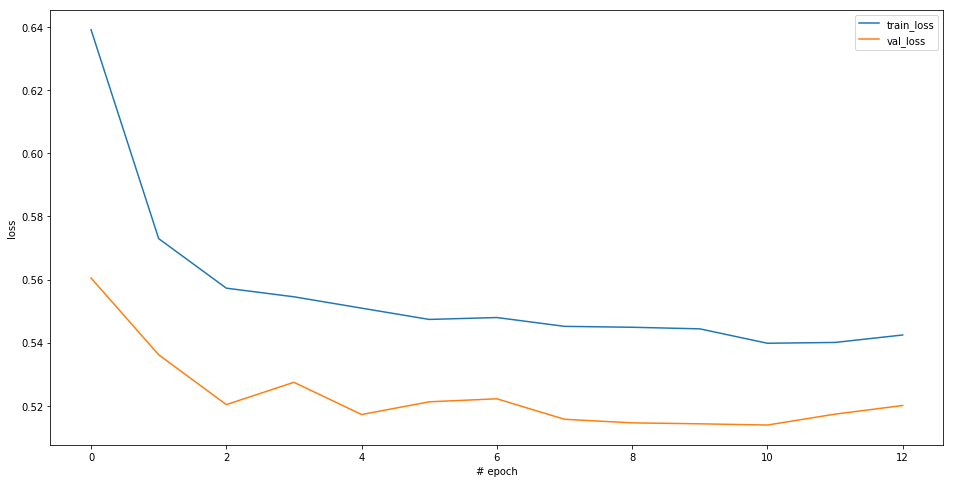

Train loss: 0.542
Val loss: 0.520



In [563]:
features = torch.from_numpy(df_train_features.values).type(torch.FloatTensor)
targets = torch.from_numpy(df_train_targets.radiant_win.values.astype('float')).type(torch.FloatTensor)
train_loader, val_loader = train_val_split(features, targets, train_batch_size=256, val_batch_size=256)
_, in_size = features.shape
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])

In [564]:
compute_score(model, val_loader)

0.8153384257436574

In [134]:
features = torch.from_numpy(X).type(torch.float)

In [135]:
train_loader, val_loader = train_val_split(features, targets, train_batch_size=256, val_batch_size=256)

In [142]:
_, in_size = train_loader.dataset.tensors[0].shape

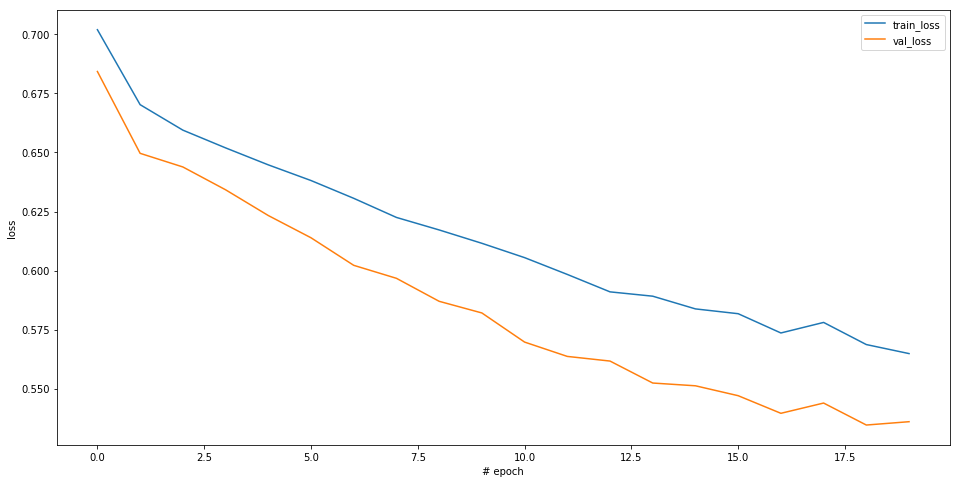

Train loss: 0.565
Val loss: 0.536



In [88]:
model = WinRatePredictor(in_size, activation=nn.Sigmoid)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.05, patience=10)])

In [89]:
compute_score(model, val_loader)

0.8061021552216205

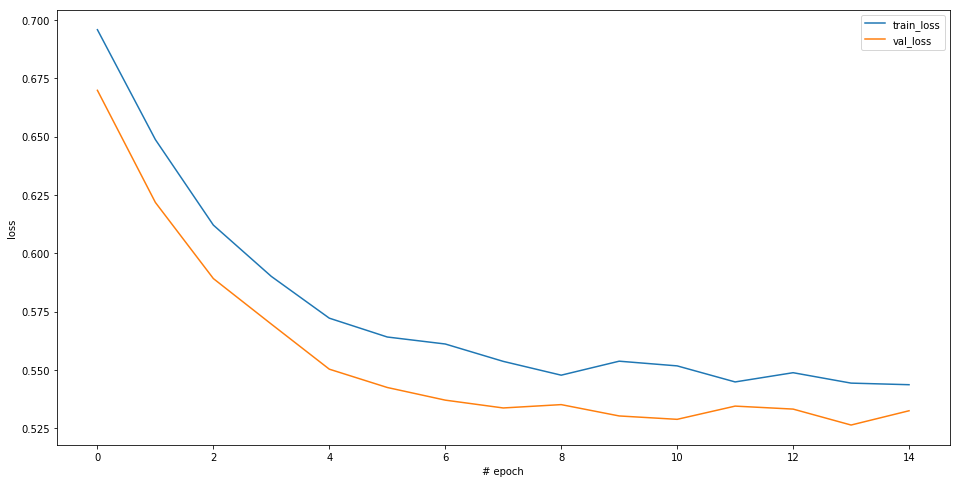

Train loss: 0.544
Val loss: 0.533



In [143]:
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])

In [144]:
compute_score(model, val_loader)

0.8081862199374953

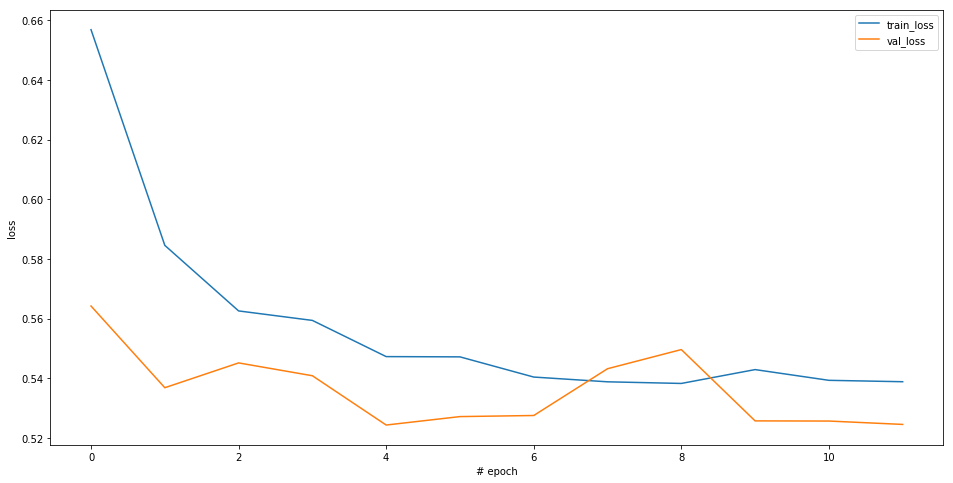

Train loss: 0.539
Val loss: 0.524



In [96]:
model = WinRatePredictor(in_size, activation=nn.SELU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])

In [97]:
compute_score(model, val_loader)

0.8087613119307555

In [28]:
import lightgbm as lgb

In [51]:
X_dataset = lgb.Dataset(X, y)

In [52]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 2,
    'nthread': -1
}

In [53]:
gbm_classifier = lgb.LGBMClassifier(**params)

In [146]:
param_grid = {
    'learning_rate': np.logspace(-3, -1, num=5, base=3),
    'max_depth': np.logspace(1, 4, num=4, base=2, dtype=int)
}
grid_search = GridSearchCV(gbm_classifier, param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] learning_rate=0.037037037037037035, max_depth=2 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=2, total=   0.8s
[CV] learning_rate=0.037037037037037035, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .. learning_rate=0.037037037037037035, max_depth=2, total=   1.2s
[CV] learning_rate=0.037037037037037035, max_depth=2 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=2, total=   0.7s
[CV] learning_rate=0.037037037037037035, max_depth=2 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=2, total=   0.9s
[CV] learning_rate=0.037037037037037035, max_depth=2 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=2, total=   0.8s
[CV] learning_rate=0.037037037037037035, max_depth=4 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=4, total=   1.3s
[CV] learning_rate=0.037037037037037035, max_depth=4 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=4, total=   1.0s
[CV] learning_rate=0.037037037037037035, max_depth=4 .................
[CV] .. learning_rate=0.037037037037037035, max_depth=4, total=   1.6s
[CV] learning_rate=0.037037037037037035, max_depth=4 .................
[CV] .

[CV] ... learning_rate=0.1111111111111111, max_depth=16, total=   2.7s
[CV] learning_rate=0.19245008972987526, max_depth=2 ..................
[CV] ... learning_rate=0.19245008972987526, max_depth=2, total=   0.6s
[CV] learning_rate=0.19245008972987526, max_depth=2 ..................
[CV] ... learning_rate=0.19245008972987526, max_depth=2, total=   0.6s
[CV] learning_rate=0.19245008972987526, max_depth=2 ..................
[CV] ... learning_rate=0.19245008972987526, max_depth=2, total=   0.7s
[CV] learning_rate=0.19245008972987526, max_depth=2 ..................
[CV] ... learning_rate=0.19245008972987526, max_depth=2, total=   0.5s
[CV] learning_rate=0.19245008972987526, max_depth=2 ..................
[CV] ... learning_rate=0.19245008972987526, max_depth=2, total=   0.9s
[CV] learning_rate=0.19245008972987526, max_depth=4 ..................
[CV] ... learning_rate=0.19245008972987526, max_depth=4, total=   0.9s
[CV] learning_rate=0.19245008972987526, max_depth=4 ..................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        learning_rate=0.050694003949711165, max_depth=10, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0...mbda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, verbose=2),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.03704, 0.06415, 0.11111, 0.19245, 0.33333]), 'max_depth': array([ 2,  4,  8, 16])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [148]:
gbm_classifier.set_params(**grid_search.best_params_)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        learning_rate=0.037037037037037035, max_depth=4, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, nthread=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, verbose=2)

In [156]:
param_grid = {'n_estimators': np.linspace(500, 1000, num=3, dtype=int)}
grid_search = GridSearchCV(gbm_classifier, param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   4.9s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] ................................. n_estimators=500, total=   5.4s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   4.3s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   5.9s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   4.8s
[CV] n_estimators=750 ................................................
[CV] ................................. n_estimators=750, total=   7.4s
[CV] n_estimators=750 ................................................
[CV] ................................. n_estimators=750, total=   5.3s
[CV] n_estimators=750 ................................................
[CV] ................................. n_estimators=750, total=   6.2s
[CV] n_estimators=750 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        learning_rate=0.037037037037037035, max_depth=4, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,...mbda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, verbose=2),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 500,  750, 1000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [157]:
grid_search.best_estimator_

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        learning_rate=0.037037037037037035, max_depth=4, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, nthread=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, verbose=2)

In [29]:
import catboost

In [158]:
catboost_classifier = catboost.CatBoostClassifier(loss_function='Logloss',
                                                  learning_rate=0.05, max_depth=4, n_estimators=500)

In [159]:
catboost_cv_score = cross_val_score(catboost_classifier, X, y, scoring='roc_auc', cv=3)
print(catboost_cv_score)
print(catboost_cv_score.mean())

0:	learn: 0.6794679	total: 110ms	remaining: 54.9s
1:	learn: 0.6681490	total: 172ms	remaining: 42.9s
2:	learn: 0.6568650	total: 220ms	remaining: 36.5s
3:	learn: 0.6477581	total: 292ms	remaining: 36.2s
4:	learn: 0.6397209	total: 402ms	remaining: 39.8s
5:	learn: 0.6326566	total: 486ms	remaining: 40s
6:	learn: 0.6257535	total: 557ms	remaining: 39.2s
7:	learn: 0.6195131	total: 629ms	remaining: 38.7s
8:	learn: 0.6140821	total: 700ms	remaining: 38.2s
9:	learn: 0.6093717	total: 831ms	remaining: 40.7s
10:	learn: 0.6042102	total: 935ms	remaining: 41.6s
11:	learn: 0.5999037	total: 1s	remaining: 40.7s
12:	learn: 0.5944785	total: 1.1s	remaining: 41.2s
13:	learn: 0.5900862	total: 1.23s	remaining: 42.6s
14:	learn: 0.5872546	total: 1.33s	remaining: 43s
15:	learn: 0.5837461	total: 1.4s	remaining: 42.3s
16:	learn: 0.5806856	total: 1.48s	remaining: 42.1s
17:	learn: 0.5771459	total: 1.57s	remaining: 42s
18:	learn: 0.5746916	total: 1.63s	remaining: 41.3s
19:	learn: 0.5720372	total: 1.75s	remaining: 42.1s
2

161:	learn: 0.5074530	total: 14.3s	remaining: 29.8s
162:	learn: 0.5073285	total: 14.4s	remaining: 29.7s
163:	learn: 0.5070946	total: 14.5s	remaining: 29.7s
164:	learn: 0.5067345	total: 14.6s	remaining: 29.6s
165:	learn: 0.5064598	total: 14.6s	remaining: 29.4s
166:	learn: 0.5062592	total: 14.7s	remaining: 29.4s
167:	learn: 0.5061048	total: 14.8s	remaining: 29.2s
168:	learn: 0.5059582	total: 14.9s	remaining: 29.1s
169:	learn: 0.5057849	total: 15s	remaining: 29.1s
170:	learn: 0.5056091	total: 15.1s	remaining: 29s
171:	learn: 0.5054224	total: 15.2s	remaining: 29s
172:	learn: 0.5051818	total: 15.3s	remaining: 28.8s
173:	learn: 0.5050817	total: 15.3s	remaining: 28.7s
174:	learn: 0.5049097	total: 15.5s	remaining: 28.7s
175:	learn: 0.5047540	total: 15.5s	remaining: 28.6s
176:	learn: 0.5045081	total: 15.6s	remaining: 28.5s
177:	learn: 0.5043023	total: 15.7s	remaining: 28.3s
178:	learn: 0.5041018	total: 15.8s	remaining: 28.3s
179:	learn: 0.5038328	total: 15.9s	remaining: 28.3s
180:	learn: 0.5036

320:	learn: 0.4717568	total: 27.6s	remaining: 15.4s
321:	learn: 0.4716238	total: 27.6s	remaining: 15.3s
322:	learn: 0.4714992	total: 27.7s	remaining: 15.2s
323:	learn: 0.4712799	total: 27.8s	remaining: 15.1s
324:	learn: 0.4711333	total: 27.9s	remaining: 15s
325:	learn: 0.4709172	total: 27.9s	remaining: 14.9s
326:	learn: 0.4706522	total: 28.1s	remaining: 14.8s
327:	learn: 0.4705285	total: 28.1s	remaining: 14.7s
328:	learn: 0.4703762	total: 28.2s	remaining: 14.7s
329:	learn: 0.4701516	total: 28.3s	remaining: 14.6s
330:	learn: 0.4698819	total: 28.4s	remaining: 14.5s
331:	learn: 0.4697490	total: 28.5s	remaining: 14.4s
332:	learn: 0.4695201	total: 28.5s	remaining: 14.3s
333:	learn: 0.4692805	total: 28.5s	remaining: 14.2s
334:	learn: 0.4691924	total: 28.6s	remaining: 14.1s
335:	learn: 0.4690277	total: 28.6s	remaining: 14s
336:	learn: 0.4688539	total: 28.7s	remaining: 13.9s
337:	learn: 0.4685842	total: 28.8s	remaining: 13.8s
338:	learn: 0.4684183	total: 28.9s	remaining: 13.7s
339:	learn: 0.46

483:	learn: 0.4435947	total: 40.7s	remaining: 1.35s
484:	learn: 0.4434929	total: 40.8s	remaining: 1.26s
485:	learn: 0.4434155	total: 40.9s	remaining: 1.18s
486:	learn: 0.4432745	total: 40.9s	remaining: 1.09s
487:	learn: 0.4430724	total: 41s	remaining: 1.01s
488:	learn: 0.4429621	total: 41s	remaining: 923ms
489:	learn: 0.4426721	total: 41.1s	remaining: 839ms
490:	learn: 0.4424866	total: 41.1s	remaining: 754ms
491:	learn: 0.4422890	total: 41.2s	remaining: 670ms
492:	learn: 0.4421735	total: 41.2s	remaining: 585ms
493:	learn: 0.4419702	total: 41.3s	remaining: 501ms
494:	learn: 0.4417127	total: 41.3s	remaining: 417ms
495:	learn: 0.4416023	total: 41.4s	remaining: 334ms
496:	learn: 0.4413623	total: 41.5s	remaining: 250ms
497:	learn: 0.4413173	total: 41.5s	remaining: 167ms
498:	learn: 0.4411638	total: 41.6s	remaining: 83.3ms
499:	learn: 0.4410651	total: 41.6s	remaining: 0us
0:	learn: 0.6800804	total: 65.5ms	remaining: 32.7s
1:	learn: 0.6668765	total: 143ms	remaining: 35.6s
2:	learn: 0.6567418	

145:	learn: 0.5153239	total: 12.2s	remaining: 29.6s
146:	learn: 0.5150952	total: 12.3s	remaining: 29.5s
147:	learn: 0.5148905	total: 12.4s	remaining: 29.4s
148:	learn: 0.5146733	total: 12.4s	remaining: 29.3s
149:	learn: 0.5144842	total: 12.5s	remaining: 29.2s
150:	learn: 0.5142933	total: 12.6s	remaining: 29s
151:	learn: 0.5140839	total: 12.7s	remaining: 29.1s
152:	learn: 0.5137842	total: 12.8s	remaining: 29.1s
153:	learn: 0.5135310	total: 12.9s	remaining: 28.9s
154:	learn: 0.5133464	total: 13s	remaining: 28.8s
155:	learn: 0.5131434	total: 13s	remaining: 28.8s
156:	learn: 0.5128968	total: 13.1s	remaining: 28.7s
157:	learn: 0.5126666	total: 13.3s	remaining: 28.7s
158:	learn: 0.5125421	total: 13.3s	remaining: 28.6s
159:	learn: 0.5123414	total: 13.4s	remaining: 28.5s
160:	learn: 0.5121262	total: 13.5s	remaining: 28.5s
161:	learn: 0.5119184	total: 13.6s	remaining: 28.3s
162:	learn: 0.5116700	total: 13.6s	remaining: 28.2s
163:	learn: 0.5114776	total: 13.7s	remaining: 28.1s
164:	learn: 0.5112

306:	learn: 0.4819413	total: 25.7s	remaining: 16.2s
307:	learn: 0.4818128	total: 25.8s	remaining: 16.1s
308:	learn: 0.4814865	total: 25.9s	remaining: 16s
309:	learn: 0.4813791	total: 26s	remaining: 15.9s
310:	learn: 0.4811792	total: 26s	remaining: 15.8s
311:	learn: 0.4809516	total: 26.1s	remaining: 15.7s
312:	learn: 0.4807920	total: 26.2s	remaining: 15.7s
313:	learn: 0.4806369	total: 26.3s	remaining: 15.6s
314:	learn: 0.4804175	total: 26.4s	remaining: 15.5s
315:	learn: 0.4802700	total: 26.4s	remaining: 15.4s
316:	learn: 0.4801135	total: 26.5s	remaining: 15.3s
317:	learn: 0.4798900	total: 26.6s	remaining: 15.2s
318:	learn: 0.4798207	total: 26.7s	remaining: 15.1s
319:	learn: 0.4796274	total: 26.7s	remaining: 15s
320:	learn: 0.4794482	total: 26.8s	remaining: 15s
321:	learn: 0.4791650	total: 26.9s	remaining: 14.9s
322:	learn: 0.4789561	total: 27s	remaining: 14.8s
323:	learn: 0.4787772	total: 27.1s	remaining: 14.7s
324:	learn: 0.4786295	total: 27.2s	remaining: 14.6s
325:	learn: 0.4783998	to

466:	learn: 0.4521465	total: 38.6s	remaining: 2.73s
467:	learn: 0.4519900	total: 38.7s	remaining: 2.65s
468:	learn: 0.4517628	total: 38.8s	remaining: 2.56s
469:	learn: 0.4516212	total: 38.9s	remaining: 2.48s
470:	learn: 0.4514840	total: 39s	remaining: 2.4s
471:	learn: 0.4513541	total: 39s	remaining: 2.31s
472:	learn: 0.4510983	total: 39.1s	remaining: 2.23s
473:	learn: 0.4508750	total: 39.2s	remaining: 2.15s
474:	learn: 0.4506101	total: 39.2s	remaining: 2.06s
475:	learn: 0.4503446	total: 39.3s	remaining: 1.98s
476:	learn: 0.4502708	total: 39.4s	remaining: 1.9s
477:	learn: 0.4499965	total: 39.4s	remaining: 1.81s
478:	learn: 0.4498174	total: 39.5s	remaining: 1.73s
479:	learn: 0.4495045	total: 39.6s	remaining: 1.65s
480:	learn: 0.4493895	total: 39.7s	remaining: 1.57s
481:	learn: 0.4492531	total: 39.7s	remaining: 1.48s
482:	learn: 0.4490085	total: 39.8s	remaining: 1.4s
483:	learn: 0.4488086	total: 39.9s	remaining: 1.32s
484:	learn: 0.4486265	total: 40s	remaining: 1.24s
485:	learn: 0.4484766

130:	learn: 0.5080209	total: 10.5s	remaining: 29.6s
131:	learn: 0.5078260	total: 10.6s	remaining: 29.4s
132:	learn: 0.5076285	total: 10.6s	remaining: 29.3s
133:	learn: 0.5074475	total: 10.7s	remaining: 29.3s
134:	learn: 0.5071792	total: 10.8s	remaining: 29.2s
135:	learn: 0.5069432	total: 10.9s	remaining: 29.1s
136:	learn: 0.5066935	total: 10.9s	remaining: 29s
137:	learn: 0.5065379	total: 11s	remaining: 29s
138:	learn: 0.5062686	total: 11.1s	remaining: 28.9s
139:	learn: 0.5061587	total: 11.2s	remaining: 28.7s
140:	learn: 0.5058395	total: 11.3s	remaining: 28.7s
141:	learn: 0.5056262	total: 11.4s	remaining: 28.6s
142:	learn: 0.5055132	total: 11.4s	remaining: 28.6s
143:	learn: 0.5054047	total: 11.6s	remaining: 28.6s
144:	learn: 0.5052075	total: 11.7s	remaining: 28.6s
145:	learn: 0.5049846	total: 11.7s	remaining: 28.5s
146:	learn: 0.5045880	total: 11.8s	remaining: 28.3s
147:	learn: 0.5043895	total: 11.9s	remaining: 28.3s
148:	learn: 0.5042403	total: 12s	remaining: 28.2s
149:	learn: 0.504073

291:	learn: 0.4719906	total: 23.5s	remaining: 16.8s
292:	learn: 0.4718175	total: 23.6s	remaining: 16.7s
293:	learn: 0.4714988	total: 23.6s	remaining: 16.6s
294:	learn: 0.4712235	total: 23.7s	remaining: 16.5s
295:	learn: 0.4710854	total: 23.7s	remaining: 16.3s
296:	learn: 0.4708326	total: 23.8s	remaining: 16.3s
297:	learn: 0.4706660	total: 23.8s	remaining: 16.2s
298:	learn: 0.4705044	total: 23.9s	remaining: 16.1s
299:	learn: 0.4703090	total: 24s	remaining: 16s
300:	learn: 0.4700696	total: 24.1s	remaining: 15.9s
301:	learn: 0.4698883	total: 24.1s	remaining: 15.8s
302:	learn: 0.4696299	total: 24.2s	remaining: 15.7s
303:	learn: 0.4693626	total: 24.3s	remaining: 15.7s
304:	learn: 0.4691955	total: 24.4s	remaining: 15.6s
305:	learn: 0.4689322	total: 24.5s	remaining: 15.5s
306:	learn: 0.4688150	total: 24.5s	remaining: 15.4s
307:	learn: 0.4685229	total: 24.6s	remaining: 15.3s
308:	learn: 0.4683179	total: 24.7s	remaining: 15.3s
309:	learn: 0.4682303	total: 24.8s	remaining: 15.2s
310:	learn: 0.46

450:	learn: 0.4429233	total: 37s	remaining: 4.02s
451:	learn: 0.4428521	total: 37s	remaining: 3.93s
452:	learn: 0.4426430	total: 37.1s	remaining: 3.85s
453:	learn: 0.4424551	total: 37.2s	remaining: 3.77s
454:	learn: 0.4422322	total: 37.3s	remaining: 3.69s
455:	learn: 0.4419406	total: 37.4s	remaining: 3.61s
456:	learn: 0.4416745	total: 37.5s	remaining: 3.53s
457:	learn: 0.4415682	total: 37.6s	remaining: 3.44s
458:	learn: 0.4413833	total: 37.6s	remaining: 3.36s
459:	learn: 0.4411702	total: 37.7s	remaining: 3.28s
460:	learn: 0.4409472	total: 37.8s	remaining: 3.2s
461:	learn: 0.4407259	total: 37.9s	remaining: 3.12s
462:	learn: 0.4406336	total: 37.9s	remaining: 3.03s
463:	learn: 0.4404791	total: 38s	remaining: 2.95s
464:	learn: 0.4402130	total: 38.1s	remaining: 2.87s
465:	learn: 0.4400959	total: 38.2s	remaining: 2.79s
466:	learn: 0.4399195	total: 38.3s	remaining: 2.71s
467:	learn: 0.4397874	total: 38.4s	remaining: 2.63s
468:	learn: 0.4395951	total: 38.5s	remaining: 2.54s
469:	learn: 0.43937

In [30]:
def make_roshan_target(x, mode='every'):
    if mode == 'every':
        if x is None or isinstance(x, float) and math.isnan(x):
            return 0
        elif x == 'Radiant':
            return 1
        else:
            return 2
    elif mode == 'be_or_not':
        if x is None or isinstance(x, float) and math.isnan(x):
            return 0
        else:
            return 1
    elif mode == 'radiant_vs_dire':
        if x is None or isinstance(x, float) and math.isnan(x):
            return np.nan
        elif x == 'Radiant':
            return 0
        else:
            return 1

In [31]:
def cross_entropy(input, target):
    return F.cross_entropy(input, target, size_average=False)

In [260]:
next_roshan_team_radiant_vs_dire = df_train_targets['next_roshan_team'] \
    .map(lambda x: make_roshan_target(x, mode='radiant_vs_dire')).values.astype('float32')
active = ~np.isnan(next_roshan_team_radiant_vs_dire)
active, *_ = np.where(active)

In [263]:
next_roshan_team_be_or_not = df_train_targets['next_roshan_team'] \
    .map(lambda x: make_roshan_target(x, mode='be_or_not')).values.astype('float32')

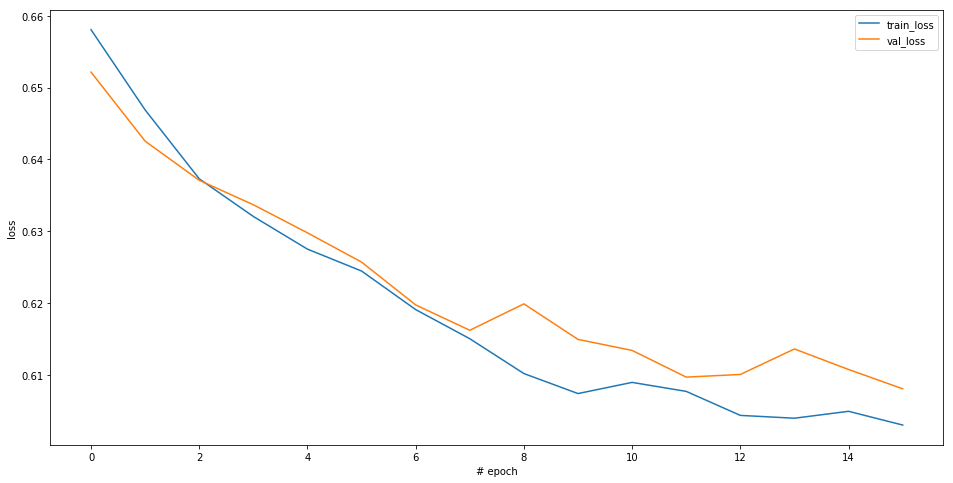

Train loss: 0.603
Val loss: 0.608



In [267]:
train_loader, val_loader = train_val_split(
    features,
    torch.from_numpy(next_roshan_team_be_or_not),
    train_batch_size=256, val_batch_size=256
)
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      loss_function=binary_cross_entropy_with_logits,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])

In [268]:
compute_score(model, val_loader)

0.6520623422587375

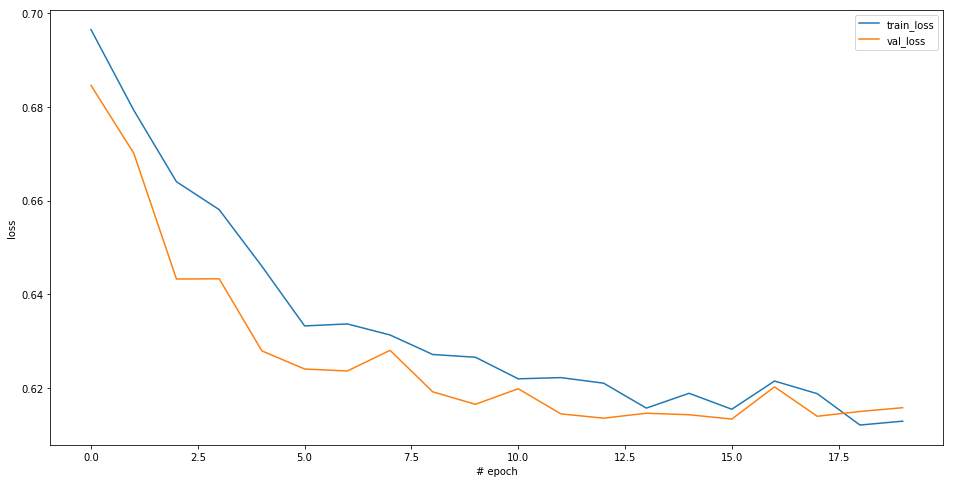

Train loss: 0.613
Val loss: 0.616



In [269]:
train_loader, val_loader = train_val_split(
    features[active],
    torch.from_numpy(next_roshan_team_radiant_vs_dire)[active],
    train_batch_size=256, val_batch_size=256
)
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      loss_function=binary_cross_entropy_with_logits,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])

In [270]:
compute_score(model, val_loader)

0.7144750688036264

In [32]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

In [33]:
def export_picks_from_file(filename, sparse=False):
    picks = []
    for i, match in enumerate(read_matches(filename)):
        row = []
        for player in match['players']:
            hero_id = player['hero_id']
            row.append(hero_id)
        picks.append(np.array(row))
    picks = np.vstack(picks)
    mlb = MultiLabelBinarizer(classes=np.arange(picks.min(), picks.max() + 1), sparse_output=sparse)
    picks_ohe = mlb.fit_transform(picks)
    if sparse:
        picks_ohe = picks_ohe.tolil()
    for (row, _), value in np.ndenumerate(picks[:, 5:]):
        picks_ohe[row, value - 1] *= -1
    return picks_ohe

In [430]:
picks_sparse = export_picks_from_file('data/train_matches.jsonlines', sparse=True)
picks_dense = np.array(picks_sparse.todense())

HBox(children=(IntProgress(value=0, max=10801), HTML(value='')))

In [437]:
picks = picks_dense.astype('float32')
picks_column_names = ('hero_%d_pick' % (hero_id) for hero_id in range(1, picks.shape[1] + 1))
picks_dict = {name: values for name, values in zip(picks_column_names, picks.T)}
df_train_features_extended = df_train_features.copy()
add_new_features(df_train_features_extended,
                 logits=predictions_logits, **picks_dict)

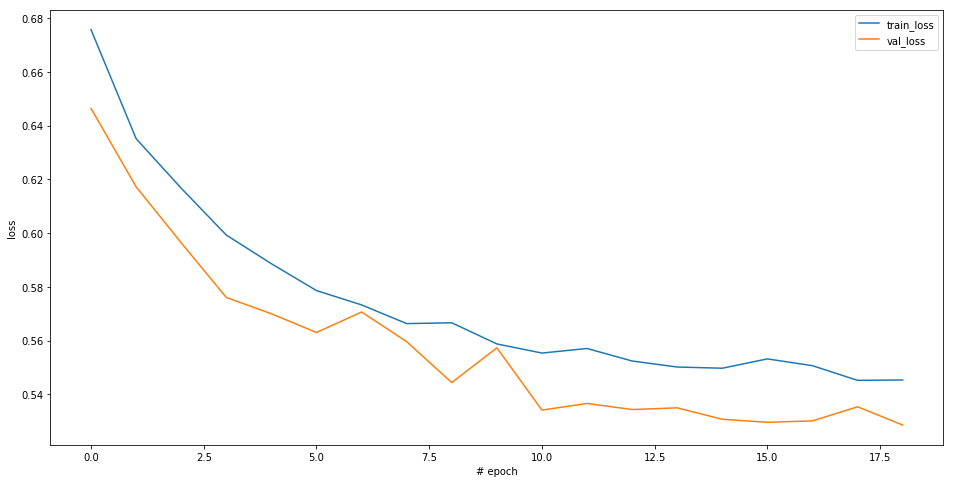

Train loss: 0.545
Val loss: 0.529



In [438]:
_, in_size = df_train_features_extended.shape
train_loader, val_loader = train_val_split(
    torch.from_numpy(df_train_features_extended.values).type(torch.float),
    torch.from_numpy(df_train_targets.radiant_win.values.astype('float')).type(torch.float),
    train_batch_size=256, val_batch_size=256
)
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, train_loader, val_loader, num_epochs=100,
      callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])

In [439]:
compute_score(model, val_loader)

0.8087458616981008

# Оценка всего

In [34]:
import scipy.sparse as sps

In [35]:
try:
    df_train_features = pd.read_csv('data_final/train_features.csv', index_col='match_id_hash')
    df_train_targets = pd.read_csv('data_final/train_targets.csv')
except:
    df_train_features, df_train_targets = features_targets_from_json_to_csv('data_final/train_matches.jsonl')
    df_train_features.to_csv('data_final/train_features.csv', index_label='match_id_hash')
    df_train_targets.to_csv('data_final/train_targets.csv')

In [36]:
try:
    picks_sparse = sps.load_npz('data_final/picks.npz').tolil()
except:
    picks_sparse = export_picks_from_file('data_final/train_matches.jsonl', sparse=True)
    sps.save_npz('data_final/picks.npz', picks_sparse.tocsc())
picks_dense = np.array(picks_sparse.todense())

In [118]:
df_train_features = pd.read_csv('data_final/train_features.csv', index_col='match_id_hash')
df_train_targets = pd.read_csv('data_final/train_targets.csv')

# Win predict

### Модели на пиках

###### FM

In [37]:
from fastFM.als import FMClassification
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import log_loss, f1_score
from sklearn.base import clone

In [38]:
def fm_classifier_cross_val_score(clf, X, y, scoring_function=roc_auc_score, n_splits=5,
                                  shuffle=False, random_state=0):
    cv_score = []
    cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    split = cv.split(y)
    for train_idx, val_idx in split:
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_val)
        score = scoring_function(y_val, y_pred)
        cv_score.append(score)
    return np.array(cv_score)

In [39]:
def fm_classifier_grid_search(clf, params, X, y, scoring_function=roc_auc_score):
    best_score = 0.
    best_params = {}
    for kwargs in ParameterGrid(params):
        clf_ = clone(clf)
        clf_.set_params(**kwargs)
        cv_score = fm_classifier_cross_val_score(clf_, X, y)
        mean_cv_score = cv_score.mean()
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = kwargs.copy()
    return best_score, best_params

In [476]:
X = picks_sparse
y = 2 * df_train_targets.radiant_win.values.astype('float32') - 1
params = {
    'rank': np.arange(4, 16, 2),
    'l2_reg_w': np.arange(0.05, 0.21, 0.05),
    'l2_reg_V': np.arange(0.05, 0.21, 0.05)
}
fm_classifier = FMClassification()
best_score, best_params = fm_classifier_grid_search(fm_classifier, params, X, y)
print('Best score: {:.3f}'.format(best_score))
print('Best params: {}'.format(best_params))

Best score: 0.521
Best params: {'l2_reg_V': 0.2, 'l2_reg_w': 0.2, 'rank': 4}


##### CatBoost

In [474]:
X = picks_dense
y = df_train_targets.radiant_win.values.astype('float32')
catboost_clf = catboost.CatBoostClassifier(iterations=500)
catboost_cv_score = cross_val_score(catboost_clf, X, y, scoring='roc_auc')

0:	learn: 0.6927016	total: 189ms	remaining: 1m 34s
1:	learn: 0.6922743	total: 382ms	remaining: 1m 35s
2:	learn: 0.6919018	total: 586ms	remaining: 1m 37s
3:	learn: 0.6915589	total: 810ms	remaining: 1m 40s
4:	learn: 0.6911693	total: 1.06s	remaining: 1m 45s
5:	learn: 0.6908734	total: 1.31s	remaining: 1m 47s
6:	learn: 0.6906190	total: 1.53s	remaining: 1m 47s
7:	learn: 0.6903160	total: 1.78s	remaining: 1m 49s
8:	learn: 0.6900531	total: 1.96s	remaining: 1m 47s
9:	learn: 0.6897951	total: 2.31s	remaining: 1m 53s
10:	learn: 0.6895834	total: 2.43s	remaining: 1m 47s
11:	learn: 0.6893198	total: 2.53s	remaining: 1m 43s
12:	learn: 0.6890451	total: 2.68s	remaining: 1m 40s
13:	learn: 0.6888255	total: 2.85s	remaining: 1m 38s
14:	learn: 0.6886179	total: 3.11s	remaining: 1m 40s
15:	learn: 0.6884601	total: 3.38s	remaining: 1m 42s
16:	learn: 0.6882510	total: 3.61s	remaining: 1m 42s
17:	learn: 0.6880228	total: 3.81s	remaining: 1m 42s
18:	learn: 0.6878184	total: 4.04s	remaining: 1m 42s
19:	learn: 0.6876196	t

158:	learn: 0.6732977	total: 30.5s	remaining: 1m 5s
159:	learn: 0.6732315	total: 30.6s	remaining: 1m 5s
160:	learn: 0.6731699	total: 31s	remaining: 1m 5s
161:	learn: 0.6731099	total: 31.2s	remaining: 1m 5s
162:	learn: 0.6730362	total: 31.4s	remaining: 1m 4s
163:	learn: 0.6729562	total: 31.6s	remaining: 1m 4s
164:	learn: 0.6728986	total: 31.8s	remaining: 1m 4s
165:	learn: 0.6728085	total: 31.9s	remaining: 1m 4s
166:	learn: 0.6727271	total: 32.1s	remaining: 1m 3s
167:	learn: 0.6726556	total: 32.2s	remaining: 1m 3s
168:	learn: 0.6725657	total: 32.3s	remaining: 1m 3s
169:	learn: 0.6724875	total: 32.4s	remaining: 1m 2s
170:	learn: 0.6724100	total: 32.6s	remaining: 1m 2s
171:	learn: 0.6723351	total: 32.8s	remaining: 1m 2s
172:	learn: 0.6722473	total: 33s	remaining: 1m 2s
173:	learn: 0.6721885	total: 33.2s	remaining: 1m 2s
174:	learn: 0.6721151	total: 33.4s	remaining: 1m 2s
175:	learn: 0.6720394	total: 33.7s	remaining: 1m 1s
176:	learn: 0.6719763	total: 33.8s	remaining: 1m 1s
177:	learn: 0.67

317:	learn: 0.6628980	total: 57.9s	remaining: 33.1s
318:	learn: 0.6628290	total: 58.1s	remaining: 33s
319:	learn: 0.6627834	total: 58.3s	remaining: 32.8s
320:	learn: 0.6626996	total: 58.5s	remaining: 32.6s
321:	learn: 0.6626269	total: 58.7s	remaining: 32.4s
322:	learn: 0.6625635	total: 58.9s	remaining: 32.3s
323:	learn: 0.6624828	total: 59.2s	remaining: 32.1s
324:	learn: 0.6624161	total: 59.4s	remaining: 32s
325:	learn: 0.6623396	total: 59.6s	remaining: 31.8s
326:	learn: 0.6622588	total: 59.8s	remaining: 31.6s
327:	learn: 0.6622019	total: 60s	remaining: 31.5s
328:	learn: 0.6621448	total: 1m	remaining: 31.3s
329:	learn: 0.6620892	total: 1m	remaining: 31.1s
330:	learn: 0.6620176	total: 1m	remaining: 30.9s
331:	learn: 0.6619524	total: 1m	remaining: 30.7s
332:	learn: 0.6618778	total: 1m	remaining: 30.5s
333:	learn: 0.6618263	total: 1m 1s	remaining: 30.3s
334:	learn: 0.6617688	total: 1m 1s	remaining: 30.1s
335:	learn: 0.6616980	total: 1m 1s	remaining: 30s
336:	learn: 0.6616344	total: 1m 1s	

475:	learn: 0.6525538	total: 1m 25s	remaining: 4.32s
476:	learn: 0.6525001	total: 1m 25s	remaining: 4.14s
477:	learn: 0.6524338	total: 1m 26s	remaining: 3.96s
478:	learn: 0.6523702	total: 1m 26s	remaining: 3.78s
479:	learn: 0.6523188	total: 1m 26s	remaining: 3.6s
480:	learn: 0.6522595	total: 1m 26s	remaining: 3.42s
481:	learn: 0.6521839	total: 1m 26s	remaining: 3.24s
482:	learn: 0.6521097	total: 1m 27s	remaining: 3.06s
483:	learn: 0.6520512	total: 1m 27s	remaining: 2.88s
484:	learn: 0.6519712	total: 1m 27s	remaining: 2.7s
485:	learn: 0.6519094	total: 1m 27s	remaining: 2.52s
486:	learn: 0.6518321	total: 1m 27s	remaining: 2.34s
487:	learn: 0.6517783	total: 1m 27s	remaining: 2.16s
488:	learn: 0.6517372	total: 1m 27s	remaining: 1.98s
489:	learn: 0.6516608	total: 1m 28s	remaining: 1.8s
490:	learn: 0.6515838	total: 1m 28s	remaining: 1.61s
491:	learn: 0.6515173	total: 1m 28s	remaining: 1.44s
492:	learn: 0.6514538	total: 1m 28s	remaining: 1.25s
493:	learn: 0.6513708	total: 1m 28s	remaining: 1.

134:	learn: 0.6767223	total: 27.1s	remaining: 1m 13s
135:	learn: 0.6766499	total: 27.4s	remaining: 1m 13s
136:	learn: 0.6765557	total: 27.6s	remaining: 1m 13s
137:	learn: 0.6765055	total: 27.8s	remaining: 1m 12s
138:	learn: 0.6764247	total: 28.1s	remaining: 1m 12s
139:	learn: 0.6763461	total: 28.2s	remaining: 1m 12s
140:	learn: 0.6762740	total: 28.5s	remaining: 1m 12s
141:	learn: 0.6761897	total: 28.7s	remaining: 1m 12s
142:	learn: 0.6761024	total: 28.9s	remaining: 1m 12s
143:	learn: 0.6760257	total: 29.1s	remaining: 1m 12s
144:	learn: 0.6759494	total: 29.4s	remaining: 1m 12s
145:	learn: 0.6758689	total: 29.6s	remaining: 1m 11s
146:	learn: 0.6758017	total: 29.8s	remaining: 1m 11s
147:	learn: 0.6757355	total: 30s	remaining: 1m 11s
148:	learn: 0.6756539	total: 30.1s	remaining: 1m 10s
149:	learn: 0.6755654	total: 30.1s	remaining: 1m 10s
150:	learn: 0.6754841	total: 30.3s	remaining: 1m 9s
151:	learn: 0.6754045	total: 30.4s	remaining: 1m 9s
152:	learn: 0.6753476	total: 30.5s	remaining: 1m 9

294:	learn: 0.6657157	total: 56.7s	remaining: 39.4s
295:	learn: 0.6656493	total: 57s	remaining: 39.3s
296:	learn: 0.6655904	total: 57.1s	remaining: 39s
297:	learn: 0.6655274	total: 57.2s	remaining: 38.8s
298:	learn: 0.6654709	total: 57.3s	remaining: 38.5s
299:	learn: 0.6654035	total: 57.5s	remaining: 38.3s
300:	learn: 0.6653572	total: 57.6s	remaining: 38.1s
301:	learn: 0.6653020	total: 57.8s	remaining: 37.9s
302:	learn: 0.6652544	total: 58s	remaining: 37.7s
303:	learn: 0.6652087	total: 58.1s	remaining: 37.5s
304:	learn: 0.6651450	total: 58.3s	remaining: 37.3s
305:	learn: 0.6650655	total: 58.5s	remaining: 37.1s
306:	learn: 0.6650061	total: 58.7s	remaining: 36.9s
307:	learn: 0.6649572	total: 58.9s	remaining: 36.7s
308:	learn: 0.6649129	total: 59s	remaining: 36.5s
309:	learn: 0.6648452	total: 59.2s	remaining: 36.3s
310:	learn: 0.6647769	total: 59.4s	remaining: 36.1s
311:	learn: 0.6647142	total: 59.6s	remaining: 35.9s
312:	learn: 0.6646584	total: 59.7s	remaining: 35.7s
313:	learn: 0.664601

452:	learn: 0.6553629	total: 1m 22s	remaining: 8.61s
453:	learn: 0.6552887	total: 1m 23s	remaining: 8.42s
454:	learn: 0.6552302	total: 1m 23s	remaining: 8.23s
455:	learn: 0.6551592	total: 1m 23s	remaining: 8.04s
456:	learn: 0.6550977	total: 1m 23s	remaining: 7.86s
457:	learn: 0.6550407	total: 1m 23s	remaining: 7.68s
458:	learn: 0.6549678	total: 1m 23s	remaining: 7.5s
459:	learn: 0.6549122	total: 1m 24s	remaining: 7.32s
460:	learn: 0.6548657	total: 1m 24s	remaining: 7.13s
461:	learn: 0.6547987	total: 1m 24s	remaining: 6.94s
462:	learn: 0.6547577	total: 1m 24s	remaining: 6.76s
463:	learn: 0.6546812	total: 1m 24s	remaining: 6.57s
464:	learn: 0.6546148	total: 1m 24s	remaining: 6.39s
465:	learn: 0.6545615	total: 1m 25s	remaining: 6.21s
466:	learn: 0.6544991	total: 1m 25s	remaining: 6.02s
467:	learn: 0.6544349	total: 1m 25s	remaining: 5.84s
468:	learn: 0.6543762	total: 1m 25s	remaining: 5.66s
469:	learn: 0.6543012	total: 1m 25s	remaining: 5.48s
470:	learn: 0.6542200	total: 1m 26s	remaining: 

110:	learn: 0.6768862	total: 17.4s	remaining: 1m
111:	learn: 0.6768100	total: 17.5s	remaining: 1m
112:	learn: 0.6767764	total: 17.7s	remaining: 1m
113:	learn: 0.6766809	total: 17.9s	remaining: 1m
114:	learn: 0.6766020	total: 18.1s	remaining: 1m
115:	learn: 0.6765310	total: 18.3s	remaining: 1m
116:	learn: 0.6764480	total: 18.5s	remaining: 1m
117:	learn: 0.6763771	total: 18.7s	remaining: 1m
118:	learn: 0.6763182	total: 18.8s	remaining: 1m
119:	learn: 0.6762243	total: 19s	remaining: 1m
120:	learn: 0.6761199	total: 19.2s	remaining: 1m
121:	learn: 0.6760381	total: 19.4s	remaining: 1m
122:	learn: 0.6759652	total: 19.6s	remaining: 1m
123:	learn: 0.6758956	total: 19.8s	remaining: 1m
124:	learn: 0.6758015	total: 20s	remaining: 59.9s
125:	learn: 0.6757258	total: 20.1s	remaining: 59.7s
126:	learn: 0.6756394	total: 20.3s	remaining: 59.7s
127:	learn: 0.6755873	total: 20.5s	remaining: 59.6s
128:	learn: 0.6755336	total: 20.7s	remaining: 59.5s
129:	learn: 0.6754545	total: 20.9s	remaining: 59.5s
130:	l

271:	learn: 0.6657234	total: 44.3s	remaining: 37.1s
272:	learn: 0.6656435	total: 44.5s	remaining: 37s
273:	learn: 0.6655827	total: 44.6s	remaining: 36.8s
274:	learn: 0.6655317	total: 44.7s	remaining: 36.6s
275:	learn: 0.6654436	total: 44.9s	remaining: 36.4s
276:	learn: 0.6654026	total: 45.1s	remaining: 36.3s
277:	learn: 0.6653494	total: 45.4s	remaining: 36.2s
278:	learn: 0.6653071	total: 45.6s	remaining: 36.1s
279:	learn: 0.6652512	total: 45.8s	remaining: 36s
280:	learn: 0.6651860	total: 46s	remaining: 35.8s
281:	learn: 0.6651275	total: 46.2s	remaining: 35.7s
282:	learn: 0.6650675	total: 46.4s	remaining: 35.6s
283:	learn: 0.6649978	total: 46.7s	remaining: 35.5s
284:	learn: 0.6649562	total: 46.8s	remaining: 35.3s
285:	learn: 0.6648977	total: 47s	remaining: 35.2s
286:	learn: 0.6648529	total: 47.2s	remaining: 35s
287:	learn: 0.6648042	total: 47.3s	remaining: 34.8s
288:	learn: 0.6647358	total: 47.5s	remaining: 34.6s
289:	learn: 0.6646868	total: 47.6s	remaining: 34.5s
290:	learn: 0.6646180	

431:	learn: 0.6558413	total: 1m 9s	remaining: 10.9s
432:	learn: 0.6557692	total: 1m 9s	remaining: 10.7s
433:	learn: 0.6557278	total: 1m 9s	remaining: 10.6s
434:	learn: 0.6556377	total: 1m 9s	remaining: 10.4s
435:	learn: 0.6555688	total: 1m 9s	remaining: 10.2s
436:	learn: 0.6555064	total: 1m 9s	remaining: 10.1s
437:	learn: 0.6554473	total: 1m 10s	remaining: 9.92s
438:	learn: 0.6553902	total: 1m 10s	remaining: 9.76s
439:	learn: 0.6553074	total: 1m 10s	remaining: 9.59s
440:	learn: 0.6552467	total: 1m 10s	remaining: 9.44s
441:	learn: 0.6551791	total: 1m 10s	remaining: 9.28s
442:	learn: 0.6551050	total: 1m 10s	remaining: 9.12s
443:	learn: 0.6549993	total: 1m 11s	remaining: 8.96s
444:	learn: 0.6549395	total: 1m 11s	remaining: 8.81s
445:	learn: 0.6548825	total: 1m 11s	remaining: 8.65s
446:	learn: 0.6548140	total: 1m 11s	remaining: 8.49s
447:	learn: 0.6547544	total: 1m 11s	remaining: 8.33s
448:	learn: 0.6546892	total: 1m 11s	remaining: 8.17s
449:	learn: 0.6546438	total: 1m 12s	remaining: 8.01s

In [475]:
print('CV score: {:.3f}'.format(catboost_cv_score.mean()))

CV score: 0.599


##### NN

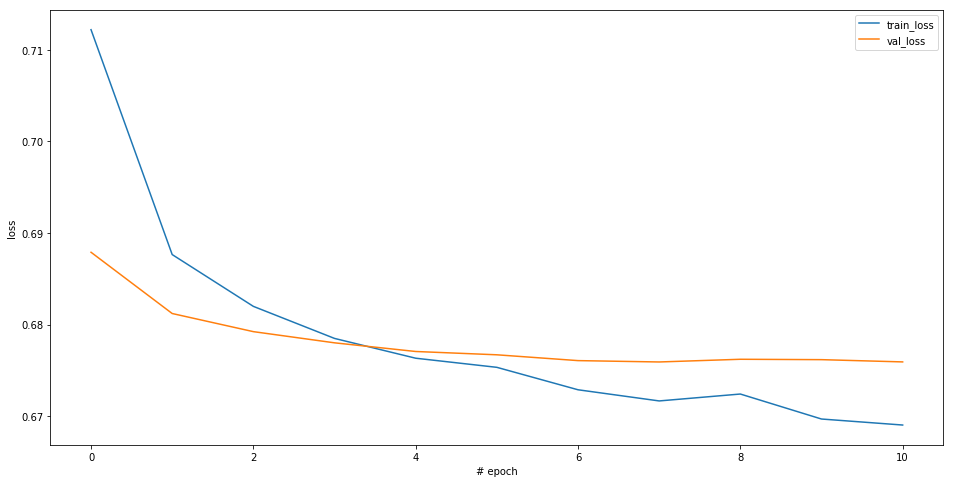

Train loss: 0.669
Val loss: 0.676



HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [364]:
_, in_size = picks_dense.shape
features = torch.from_numpy(picks_dense).type(torch.float)
targets = torch.from_numpy(df_train_targets.radiant_win.values.astype('float')).type(torch.FloatTensor)
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, TensorDataset(features, targets), train_batch_size=256, val_batch_size=256,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [365]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.605


### Стандартные фичи

##### CatBoost

In [477]:
X = df_train_features.values
y = df_train_targets.radiant_win.values.astype('float32')
catboost_clf = catboost.CatBoostClassifier(iterations=500)
catboost_cv_score = cross_val_score(catboost_clf, X, y, scoring='roc_auc')

0:	learn: 0.6885562	total: 439ms	remaining: 3m 39s
1:	learn: 0.6840319	total: 760ms	remaining: 3m 9s
2:	learn: 0.6797735	total: 1.01s	remaining: 2m 47s
3:	learn: 0.6761419	total: 1.26s	remaining: 2m 36s
4:	learn: 0.6723917	total: 1.55s	remaining: 2m 33s
5:	learn: 0.6689761	total: 1.77s	remaining: 2m 25s
6:	learn: 0.6656886	total: 2.01s	remaining: 2m 21s
7:	learn: 0.6626941	total: 2.31s	remaining: 2m 22s
8:	learn: 0.6595628	total: 2.53s	remaining: 2m 17s
9:	learn: 0.6562001	total: 2.84s	remaining: 2m 19s
10:	learn: 0.6535944	total: 3.06s	remaining: 2m 16s
11:	learn: 0.6509379	total: 3.29s	remaining: 2m 13s
12:	learn: 0.6483961	total: 3.52s	remaining: 2m 12s
13:	learn: 0.6456706	total: 3.81s	remaining: 2m 12s
14:	learn: 0.6432848	total: 4.03s	remaining: 2m 10s
15:	learn: 0.6410600	total: 4.41s	remaining: 2m 13s
16:	learn: 0.6390057	total: 4.66s	remaining: 2m 12s
17:	learn: 0.6368010	total: 4.82s	remaining: 2m 9s
18:	learn: 0.6346515	total: 5.05s	remaining: 2m 7s
19:	learn: 0.6324516	tota

159:	learn: 0.5472929	total: 44.1s	remaining: 1m 33s
160:	learn: 0.5470459	total: 44.4s	remaining: 1m 33s
161:	learn: 0.5467844	total: 44.7s	remaining: 1m 33s
162:	learn: 0.5466091	total: 45s	remaining: 1m 32s
163:	learn: 0.5463983	total: 45.3s	remaining: 1m 32s
164:	learn: 0.5462222	total: 45.5s	remaining: 1m 32s
165:	learn: 0.5460062	total: 45.7s	remaining: 1m 32s
166:	learn: 0.5457770	total: 46s	remaining: 1m 31s
167:	learn: 0.5456011	total: 46.3s	remaining: 1m 31s
168:	learn: 0.5453713	total: 46.6s	remaining: 1m 31s
169:	learn: 0.5452030	total: 46.9s	remaining: 1m 31s
170:	learn: 0.5450401	total: 47.2s	remaining: 1m 30s
171:	learn: 0.5448098	total: 47.5s	remaining: 1m 30s
172:	learn: 0.5445508	total: 47.8s	remaining: 1m 30s
173:	learn: 0.5443437	total: 48s	remaining: 1m 29s
174:	learn: 0.5441075	total: 48.2s	remaining: 1m 29s
175:	learn: 0.5439639	total: 48.5s	remaining: 1m 29s
176:	learn: 0.5437562	total: 48.7s	remaining: 1m 28s
177:	learn: 0.5435371	total: 48.9s	remaining: 1m 28s

315:	learn: 0.5217954	total: 1m 25s	remaining: 50s
316:	learn: 0.5216995	total: 1m 26s	remaining: 49.7s
317:	learn: 0.5215758	total: 1m 26s	remaining: 49.5s
318:	learn: 0.5214288	total: 1m 26s	remaining: 49.1s
319:	learn: 0.5213297	total: 1m 26s	remaining: 48.9s
320:	learn: 0.5212196	total: 1m 27s	remaining: 48.6s
321:	learn: 0.5210215	total: 1m 27s	remaining: 48.3s
322:	learn: 0.5209212	total: 1m 27s	remaining: 48s
323:	learn: 0.5207493	total: 1m 27s	remaining: 47.8s
324:	learn: 0.5205954	total: 1m 28s	remaining: 47.5s
325:	learn: 0.5204914	total: 1m 28s	remaining: 47.2s
326:	learn: 0.5203761	total: 1m 28s	remaining: 47s
327:	learn: 0.5202496	total: 1m 29s	remaining: 46.7s
328:	learn: 0.5200853	total: 1m 29s	remaining: 46.4s
329:	learn: 0.5199198	total: 1m 29s	remaining: 46.1s
330:	learn: 0.5198048	total: 1m 29s	remaining: 45.9s
331:	learn: 0.5196929	total: 1m 30s	remaining: 45.6s
332:	learn: 0.5195555	total: 1m 30s	remaining: 45.3s
333:	learn: 0.5194442	total: 1m 30s	remaining: 45.1s

471:	learn: 0.5013552	total: 2m 5s	remaining: 7.46s
472:	learn: 0.5012292	total: 2m 6s	remaining: 7.19s
473:	learn: 0.5011411	total: 2m 6s	remaining: 6.93s
474:	learn: 0.5010204	total: 2m 6s	remaining: 6.66s
475:	learn: 0.5009033	total: 2m 6s	remaining: 6.39s
476:	learn: 0.5007694	total: 2m 7s	remaining: 6.13s
477:	learn: 0.5006378	total: 2m 7s	remaining: 5.86s
478:	learn: 0.5005332	total: 2m 7s	remaining: 5.59s
479:	learn: 0.5004393	total: 2m 7s	remaining: 5.33s
480:	learn: 0.5003424	total: 2m 8s	remaining: 5.06s
481:	learn: 0.5002504	total: 2m 8s	remaining: 4.79s
482:	learn: 0.5001178	total: 2m 8s	remaining: 4.53s
483:	learn: 0.4999919	total: 2m 8s	remaining: 4.26s
484:	learn: 0.4998686	total: 2m 8s	remaining: 3.99s
485:	learn: 0.4997392	total: 2m 9s	remaining: 3.72s
486:	learn: 0.4996105	total: 2m 9s	remaining: 3.46s
487:	learn: 0.4995008	total: 2m 9s	remaining: 3.19s
488:	learn: 0.4994093	total: 2m 9s	remaining: 2.92s
489:	learn: 0.4992991	total: 2m 10s	remaining: 2.65s
490:	learn:

130:	learn: 0.5568923	total: 32.1s	remaining: 1m 30s
131:	learn: 0.5566595	total: 32.3s	remaining: 1m 30s
132:	learn: 0.5563901	total: 32.6s	remaining: 1m 29s
133:	learn: 0.5561345	total: 32.9s	remaining: 1m 29s
134:	learn: 0.5558916	total: 33.2s	remaining: 1m 29s
135:	learn: 0.5556623	total: 33.5s	remaining: 1m 29s
136:	learn: 0.5553892	total: 33.8s	remaining: 1m 29s
137:	learn: 0.5551500	total: 34.1s	remaining: 1m 29s
138:	learn: 0.5549058	total: 34.3s	remaining: 1m 29s
139:	learn: 0.5546916	total: 34.6s	remaining: 1m 28s
140:	learn: 0.5544446	total: 34.8s	remaining: 1m 28s
141:	learn: 0.5541959	total: 35s	remaining: 1m 28s
142:	learn: 0.5539255	total: 35.3s	remaining: 1m 28s
143:	learn: 0.5536687	total: 35.5s	remaining: 1m 27s
144:	learn: 0.5534897	total: 35.7s	remaining: 1m 27s
145:	learn: 0.5531711	total: 35.9s	remaining: 1m 27s
146:	learn: 0.5529594	total: 36.2s	remaining: 1m 26s
147:	learn: 0.5527328	total: 36.4s	remaining: 1m 26s
148:	learn: 0.5524353	total: 36.6s	remaining: 1m

287:	learn: 0.5278222	total: 1m 13s	remaining: 54.4s
288:	learn: 0.5276538	total: 1m 14s	remaining: 54.2s
289:	learn: 0.5275117	total: 1m 14s	remaining: 54s
290:	learn: 0.5273909	total: 1m 14s	remaining: 53.7s
291:	learn: 0.5272561	total: 1m 15s	remaining: 53.5s
292:	learn: 0.5271696	total: 1m 15s	remaining: 53.2s
293:	learn: 0.5269776	total: 1m 15s	remaining: 52.9s
294:	learn: 0.5268301	total: 1m 15s	remaining: 52.6s
295:	learn: 0.5267305	total: 1m 15s	remaining: 52.4s
296:	learn: 0.5266229	total: 1m 16s	remaining: 52.1s
297:	learn: 0.5265041	total: 1m 16s	remaining: 51.8s
298:	learn: 0.5263629	total: 1m 16s	remaining: 51.5s
299:	learn: 0.5262722	total: 1m 16s	remaining: 51.3s
300:	learn: 0.5261421	total: 1m 17s	remaining: 51s
301:	learn: 0.5259827	total: 1m 17s	remaining: 50.7s
302:	learn: 0.5258608	total: 1m 17s	remaining: 50.5s
303:	learn: 0.5257228	total: 1m 17s	remaining: 50.2s
304:	learn: 0.5255827	total: 1m 18s	remaining: 50s
305:	learn: 0.5254167	total: 1m 18s	remaining: 49.8s

443:	learn: 0.5073304	total: 1m 54s	remaining: 14.5s
444:	learn: 0.5072298	total: 1m 54s	remaining: 14.2s
445:	learn: 0.5071211	total: 1m 55s	remaining: 13.9s
446:	learn: 0.5069601	total: 1m 55s	remaining: 13.7s
447:	learn: 0.5068608	total: 1m 55s	remaining: 13.4s
448:	learn: 0.5066869	total: 1m 55s	remaining: 13.2s
449:	learn: 0.5065529	total: 1m 56s	remaining: 12.9s
450:	learn: 0.5064349	total: 1m 56s	remaining: 12.7s
451:	learn: 0.5063099	total: 1m 56s	remaining: 12.4s
452:	learn: 0.5061354	total: 1m 57s	remaining: 12.1s
453:	learn: 0.5059956	total: 1m 57s	remaining: 11.9s
454:	learn: 0.5058951	total: 1m 57s	remaining: 11.6s
455:	learn: 0.5057775	total: 1m 57s	remaining: 11.4s
456:	learn: 0.5056536	total: 1m 58s	remaining: 11.1s
457:	learn: 0.5055661	total: 1m 58s	remaining: 10.9s
458:	learn: 0.5054119	total: 1m 58s	remaining: 10.6s
459:	learn: 0.5053185	total: 1m 58s	remaining: 10.3s
460:	learn: 0.5052048	total: 1m 59s	remaining: 10.1s
461:	learn: 0.5051143	total: 1m 59s	remaining:

102:	learn: 0.5626292	total: 27.7s	remaining: 1m 46s
103:	learn: 0.5622682	total: 28s	remaining: 1m 46s
104:	learn: 0.5619003	total: 28.2s	remaining: 1m 46s
105:	learn: 0.5616050	total: 28.5s	remaining: 1m 46s
106:	learn: 0.5611749	total: 28.7s	remaining: 1m 45s
107:	learn: 0.5608671	total: 29s	remaining: 1m 45s
108:	learn: 0.5605593	total: 29.3s	remaining: 1m 44s
109:	learn: 0.5602452	total: 29.5s	remaining: 1m 44s
110:	learn: 0.5598706	total: 29.8s	remaining: 1m 44s
111:	learn: 0.5596075	total: 30s	remaining: 1m 43s
112:	learn: 0.5592915	total: 30.3s	remaining: 1m 43s
113:	learn: 0.5589962	total: 30.5s	remaining: 1m 43s
114:	learn: 0.5586497	total: 30.7s	remaining: 1m 42s
115:	learn: 0.5583249	total: 31s	remaining: 1m 42s
116:	learn: 0.5580034	total: 31.2s	remaining: 1m 42s
117:	learn: 0.5577903	total: 31.5s	remaining: 1m 41s
118:	learn: 0.5574364	total: 31.8s	remaining: 1m 41s
119:	learn: 0.5571212	total: 32s	remaining: 1m 41s
120:	learn: 0.5568226	total: 32.3s	remaining: 1m 41s
121

258:	learn: 0.5289400	total: 1m 8s	remaining: 1m 4s
259:	learn: 0.5288264	total: 1m 9s	remaining: 1m 3s
260:	learn: 0.5286672	total: 1m 9s	remaining: 1m 3s
261:	learn: 0.5285770	total: 1m 9s	remaining: 1m 3s
262:	learn: 0.5284782	total: 1m 10s	remaining: 1m 3s
263:	learn: 0.5282832	total: 1m 10s	remaining: 1m 2s
264:	learn: 0.5281702	total: 1m 10s	remaining: 1m 2s
265:	learn: 0.5280450	total: 1m 10s	remaining: 1m 2s
266:	learn: 0.5278736	total: 1m 11s	remaining: 1m 2s
267:	learn: 0.5277069	total: 1m 11s	remaining: 1m 1s
268:	learn: 0.5275751	total: 1m 11s	remaining: 1m 1s
269:	learn: 0.5274107	total: 1m 11s	remaining: 1m 1s
270:	learn: 0.5272619	total: 1m 11s	remaining: 1m
271:	learn: 0.5270994	total: 1m 12s	remaining: 1m
272:	learn: 0.5269477	total: 1m 12s	remaining: 1m
273:	learn: 0.5267848	total: 1m 12s	remaining: 60s
274:	learn: 0.5266796	total: 1m 12s	remaining: 59.7s
275:	learn: 0.5265573	total: 1m 13s	remaining: 59.4s
276:	learn: 0.5264219	total: 1m 13s	remaining: 59.1s
277:	lea

414:	learn: 0.5072235	total: 1m 48s	remaining: 22.3s
415:	learn: 0.5070596	total: 1m 49s	remaining: 22s
416:	learn: 0.5069208	total: 1m 49s	remaining: 21.8s
417:	learn: 0.5067527	total: 1m 49s	remaining: 21.5s
418:	learn: 0.5066456	total: 1m 50s	remaining: 21.3s
419:	learn: 0.5065102	total: 1m 50s	remaining: 21s
420:	learn: 0.5063448	total: 1m 50s	remaining: 20.8s
421:	learn: 0.5062281	total: 1m 50s	remaining: 20.5s
422:	learn: 0.5061028	total: 1m 51s	remaining: 20.2s
423:	learn: 0.5059578	total: 1m 51s	remaining: 20s
424:	learn: 0.5058693	total: 1m 51s	remaining: 19.7s
425:	learn: 0.5057989	total: 1m 51s	remaining: 19.4s
426:	learn: 0.5056870	total: 1m 52s	remaining: 19.2s
427:	learn: 0.5055948	total: 1m 52s	remaining: 18.9s
428:	learn: 0.5054803	total: 1m 52s	remaining: 18.7s
429:	learn: 0.5053958	total: 1m 52s	remaining: 18.4s
430:	learn: 0.5052080	total: 1m 53s	remaining: 18.1s
431:	learn: 0.5051022	total: 1m 53s	remaining: 17.8s
432:	learn: 0.5049637	total: 1m 53s	remaining: 17.6s

In [478]:
print('CV score: {:.3f}'.format(catboost_cv_score.mean()))

CV score: 0.797


##### NN

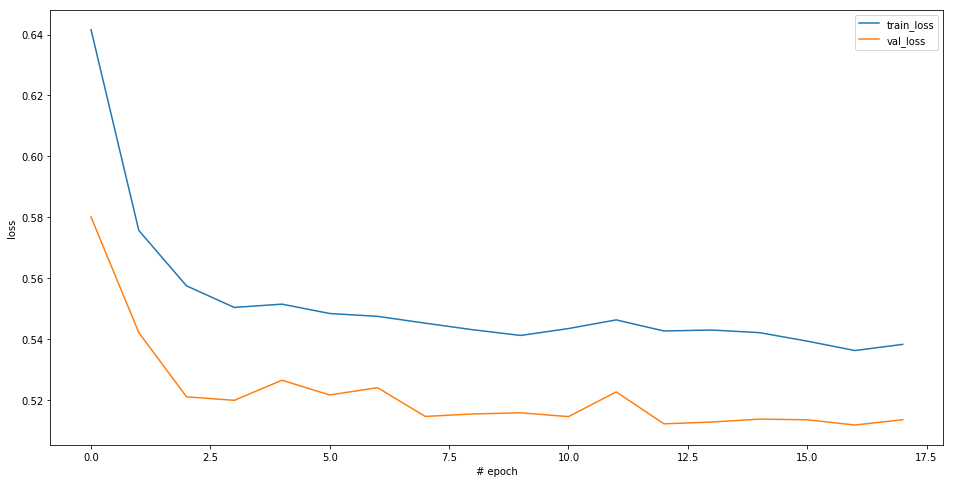

Train loss: 0.538
Val loss: 0.513



HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [362]:
features = torch.from_numpy(df_train_features.values).type(torch.float)
targets = torch.from_numpy(df_train_targets.radiant_win.values.astype('float')).type(torch.FloatTensor)
_, in_size = features.shape
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, TensorDataset(features, targets), train_batch_size=256, val_batch_size=256,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [363]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.816


### Стандартные фичи + пик

In [505]:
picks = picks_dense.astype('float32')
picks_column_names = ('hero_%d_pick' % (hero_id) for hero_id in range(1, picks.shape[1] + 1))
picks_dict = {name: values for name, values in zip(picks_column_names, picks.T)}
df_train_features_extended = df_train_features.copy()
add_new_features(df_train_features_extended, **picks_dict)

##### CatBoost

In [503]:
X = df_train_features_extended.values
y = df_train_targets.radiant_win.values.astype('float32')
catboost_clf = catboost.CatBoostClassifier(iterations=500)
catboost_cv_score = cross_val_score(catboost_clf, X, y, scoring='roc_auc')

0:	learn: 0.6883698	total: 421ms	remaining: 3m 29s
1:	learn: 0.6840491	total: 656ms	remaining: 2m 43s
2:	learn: 0.6801422	total: 929ms	remaining: 2m 33s
3:	learn: 0.6762096	total: 1.27s	remaining: 2m 37s
4:	learn: 0.6724223	total: 1.56s	remaining: 2m 34s
5:	learn: 0.6690768	total: 1.86s	remaining: 2m 33s
6:	learn: 0.6658322	total: 2.26s	remaining: 2m 38s
7:	learn: 0.6625445	total: 2.48s	remaining: 2m 32s
8:	learn: 0.6596582	total: 2.73s	remaining: 2m 28s
9:	learn: 0.6568564	total: 3.03s	remaining: 2m 28s
10:	learn: 0.6542146	total: 3.4s	remaining: 2m 31s
11:	learn: 0.6511767	total: 3.75s	remaining: 2m 32s
12:	learn: 0.6485785	total: 4.02s	remaining: 2m 30s
13:	learn: 0.6462884	total: 4.3s	remaining: 2m 29s
14:	learn: 0.6440807	total: 4.53s	remaining: 2m 26s
15:	learn: 0.6416773	total: 4.92s	remaining: 2m 28s
16:	learn: 0.6392533	total: 5.21s	remaining: 2m 28s
17:	learn: 0.6370658	total: 5.57s	remaining: 2m 29s
18:	learn: 0.6347194	total: 5.89s	remaining: 2m 29s
19:	learn: 0.6324721	tot

158:	learn: 0.5472340	total: 48.6s	remaining: 1m 44s
159:	learn: 0.5470462	total: 49s	remaining: 1m 44s
160:	learn: 0.5467690	total: 49.2s	remaining: 1m 43s
161:	learn: 0.5464750	total: 49.5s	remaining: 1m 43s
162:	learn: 0.5463152	total: 49.8s	remaining: 1m 42s
163:	learn: 0.5460558	total: 50s	remaining: 1m 42s
164:	learn: 0.5458127	total: 50.4s	remaining: 1m 42s
165:	learn: 0.5455807	total: 50.6s	remaining: 1m 41s
166:	learn: 0.5453145	total: 50.9s	remaining: 1m 41s
167:	learn: 0.5450892	total: 51.2s	remaining: 1m 41s
168:	learn: 0.5448527	total: 51.4s	remaining: 1m 40s
169:	learn: 0.5445828	total: 51.7s	remaining: 1m 40s
170:	learn: 0.5443271	total: 52s	remaining: 1m 39s
171:	learn: 0.5441020	total: 52.2s	remaining: 1m 39s
172:	learn: 0.5438710	total: 52.5s	remaining: 1m 39s
173:	learn: 0.5436195	total: 52.8s	remaining: 1m 38s
174:	learn: 0.5434080	total: 53.1s	remaining: 1m 38s
175:	learn: 0.5431980	total: 53.3s	remaining: 1m 38s
176:	learn: 0.5429940	total: 53.6s	remaining: 1m 37s

313:	learn: 0.5189376	total: 1m 34s	remaining: 55.8s
314:	learn: 0.5187972	total: 1m 34s	remaining: 55.5s
315:	learn: 0.5186157	total: 1m 34s	remaining: 55.3s
316:	learn: 0.5184192	total: 1m 35s	remaining: 55s
317:	learn: 0.5182574	total: 1m 35s	remaining: 54.8s
318:	learn: 0.5181440	total: 1m 36s	remaining: 54.5s
319:	learn: 0.5180116	total: 1m 36s	remaining: 54.2s
320:	learn: 0.5178449	total: 1m 36s	remaining: 53.9s
321:	learn: 0.5176781	total: 1m 36s	remaining: 53.5s
322:	learn: 0.5175660	total: 1m 37s	remaining: 53.2s
323:	learn: 0.5174591	total: 1m 37s	remaining: 52.9s
324:	learn: 0.5173083	total: 1m 37s	remaining: 52.5s
325:	learn: 0.5171888	total: 1m 37s	remaining: 52.2s
326:	learn: 0.5170589	total: 1m 38s	remaining: 51.9s
327:	learn: 0.5168778	total: 1m 38s	remaining: 51.6s
328:	learn: 0.5167441	total: 1m 38s	remaining: 51.3s
329:	learn: 0.5166274	total: 1m 38s	remaining: 50.9s
330:	learn: 0.5164645	total: 1m 39s	remaining: 50.6s
331:	learn: 0.5163244	total: 1m 39s	remaining: 5

469:	learn: 0.4961613	total: 2m 19s	remaining: 8.88s
470:	learn: 0.4960160	total: 2m 19s	remaining: 8.58s
471:	learn: 0.4958559	total: 2m 19s	remaining: 8.28s
472:	learn: 0.4957244	total: 2m 19s	remaining: 7.98s
473:	learn: 0.4955938	total: 2m 20s	remaining: 7.69s
474:	learn: 0.4954770	total: 2m 20s	remaining: 7.39s
475:	learn: 0.4953306	total: 2m 20s	remaining: 7.1s
476:	learn: 0.4951783	total: 2m 21s	remaining: 6.8s
477:	learn: 0.4950619	total: 2m 21s	remaining: 6.51s
478:	learn: 0.4949273	total: 2m 21s	remaining: 6.21s
479:	learn: 0.4947966	total: 2m 21s	remaining: 5.91s
480:	learn: 0.4946920	total: 2m 21s	remaining: 5.61s
481:	learn: 0.4945471	total: 2m 22s	remaining: 5.31s
482:	learn: 0.4944378	total: 2m 22s	remaining: 5.01s
483:	learn: 0.4943112	total: 2m 22s	remaining: 4.72s
484:	learn: 0.4942139	total: 2m 22s	remaining: 4.42s
485:	learn: 0.4940567	total: 2m 23s	remaining: 4.12s
486:	learn: 0.4939324	total: 2m 23s	remaining: 3.83s
487:	learn: 0.4938068	total: 2m 23s	remaining: 3

127:	learn: 0.5568856	total: 37.5s	remaining: 1m 48s
128:	learn: 0.5565293	total: 37.9s	remaining: 1m 48s
129:	learn: 0.5562200	total: 38.1s	remaining: 1m 48s
130:	learn: 0.5559428	total: 38.5s	remaining: 1m 48s
131:	learn: 0.5556342	total: 38.7s	remaining: 1m 48s
132:	learn: 0.5553408	total: 39.1s	remaining: 1m 47s
133:	learn: 0.5550108	total: 39.4s	remaining: 1m 47s
134:	learn: 0.5547089	total: 39.6s	remaining: 1m 47s
135:	learn: 0.5543743	total: 40s	remaining: 1m 46s
136:	learn: 0.5540768	total: 40.2s	remaining: 1m 46s
137:	learn: 0.5537712	total: 40.6s	remaining: 1m 46s
138:	learn: 0.5534989	total: 40.9s	remaining: 1m 46s
139:	learn: 0.5532338	total: 41.2s	remaining: 1m 45s
140:	learn: 0.5529474	total: 41.5s	remaining: 1m 45s
141:	learn: 0.5527026	total: 41.8s	remaining: 1m 45s
142:	learn: 0.5524589	total: 42.1s	remaining: 1m 45s
143:	learn: 0.5521978	total: 42.4s	remaining: 1m 44s
144:	learn: 0.5519196	total: 42.7s	remaining: 1m 44s
145:	learn: 0.5516693	total: 42.9s	remaining: 1m

282:	learn: 0.5258218	total: 1m 21s	remaining: 1m 2s
283:	learn: 0.5256863	total: 1m 22s	remaining: 1m 2s
284:	learn: 0.5255127	total: 1m 22s	remaining: 1m 2s
285:	learn: 0.5253790	total: 1m 22s	remaining: 1m 1s
286:	learn: 0.5252316	total: 1m 22s	remaining: 1m 1s
287:	learn: 0.5250775	total: 1m 23s	remaining: 1m 1s
288:	learn: 0.5249377	total: 1m 23s	remaining: 1m 1s
289:	learn: 0.5248269	total: 1m 23s	remaining: 1m
290:	learn: 0.5246779	total: 1m 24s	remaining: 1m
291:	learn: 0.5245341	total: 1m 24s	remaining: 1m
292:	learn: 0.5243806	total: 1m 24s	remaining: 59.8s
293:	learn: 0.5242124	total: 1m 24s	remaining: 59.5s
294:	learn: 0.5240707	total: 1m 25s	remaining: 59.2s
295:	learn: 0.5239426	total: 1m 25s	remaining: 58.9s
296:	learn: 0.5238151	total: 1m 25s	remaining: 58.6s
297:	learn: 0.5236174	total: 1m 26s	remaining: 58.4s
298:	learn: 0.5234560	total: 1m 26s	remaining: 58s
299:	learn: 0.5232825	total: 1m 26s	remaining: 57.7s
300:	learn: 0.5231670	total: 1m 26s	remaining: 57.4s
301:

438:	learn: 0.5023991	total: 2m 5s	remaining: 17.5s
439:	learn: 0.5022587	total: 2m 6s	remaining: 17.2s
440:	learn: 0.5020817	total: 2m 6s	remaining: 16.9s
441:	learn: 0.5018945	total: 2m 6s	remaining: 16.6s
442:	learn: 0.5017436	total: 2m 6s	remaining: 16.3s
443:	learn: 0.5015982	total: 2m 7s	remaining: 16s
444:	learn: 0.5014408	total: 2m 7s	remaining: 15.8s
445:	learn: 0.5013017	total: 2m 7s	remaining: 15.5s
446:	learn: 0.5011759	total: 2m 8s	remaining: 15.2s
447:	learn: 0.5010506	total: 2m 8s	remaining: 14.9s
448:	learn: 0.5009332	total: 2m 8s	remaining: 14.6s
449:	learn: 0.5007721	total: 2m 9s	remaining: 14.3s
450:	learn: 0.5006530	total: 2m 9s	remaining: 14s
451:	learn: 0.5005226	total: 2m 9s	remaining: 13.8s
452:	learn: 0.5003825	total: 2m 9s	remaining: 13.5s
453:	learn: 0.5002445	total: 2m 10s	remaining: 13.2s
454:	learn: 0.5001163	total: 2m 10s	remaining: 12.9s
455:	learn: 0.5000241	total: 2m 10s	remaining: 12.6s
456:	learn: 0.4998749	total: 2m 11s	remaining: 12.3s
457:	learn: 

97:	learn: 0.5640796	total: 27s	remaining: 1m 50s
98:	learn: 0.5637646	total: 27.2s	remaining: 1m 50s
99:	learn: 0.5634784	total: 27.5s	remaining: 1m 49s
100:	learn: 0.5630870	total: 27.8s	remaining: 1m 49s
101:	learn: 0.5627224	total: 28.1s	remaining: 1m 49s
102:	learn: 0.5624161	total: 28.3s	remaining: 1m 49s
103:	learn: 0.5620825	total: 28.5s	remaining: 1m 48s
104:	learn: 0.5617346	total: 28.8s	remaining: 1m 48s
105:	learn: 0.5614901	total: 29.1s	remaining: 1m 47s
106:	learn: 0.5611211	total: 29.3s	remaining: 1m 47s
107:	learn: 0.5606947	total: 29.6s	remaining: 1m 47s
108:	learn: 0.5602186	total: 30s	remaining: 1m 47s
109:	learn: 0.5598239	total: 30.2s	remaining: 1m 46s
110:	learn: 0.5594619	total: 30.5s	remaining: 1m 46s
111:	learn: 0.5591175	total: 30.7s	remaining: 1m 46s
112:	learn: 0.5587971	total: 31s	remaining: 1m 46s
113:	learn: 0.5583970	total: 31.2s	remaining: 1m 45s
114:	learn: 0.5580298	total: 31.4s	remaining: 1m 45s
115:	learn: 0.5576623	total: 31.7s	remaining: 1m 45s
11

253:	learn: 0.5269425	total: 1m 11s	remaining: 1m 9s
254:	learn: 0.5268090	total: 1m 11s	remaining: 1m 8s
255:	learn: 0.5266512	total: 1m 11s	remaining: 1m 8s
256:	learn: 0.5264588	total: 1m 12s	remaining: 1m 8s
257:	learn: 0.5262616	total: 1m 12s	remaining: 1m 7s
258:	learn: 0.5261097	total: 1m 12s	remaining: 1m 7s
259:	learn: 0.5259132	total: 1m 12s	remaining: 1m 7s
260:	learn: 0.5257170	total: 1m 13s	remaining: 1m 7s
261:	learn: 0.5255878	total: 1m 13s	remaining: 1m 6s
262:	learn: 0.5254171	total: 1m 13s	remaining: 1m 6s
263:	learn: 0.5252684	total: 1m 14s	remaining: 1m 6s
264:	learn: 0.5250841	total: 1m 14s	remaining: 1m 6s
265:	learn: 0.5249193	total: 1m 14s	remaining: 1m 5s
266:	learn: 0.5247592	total: 1m 14s	remaining: 1m 5s
267:	learn: 0.5246400	total: 1m 15s	remaining: 1m 5s
268:	learn: 0.5244727	total: 1m 15s	remaining: 1m 4s
269:	learn: 0.5243040	total: 1m 15s	remaining: 1m 4s
270:	learn: 0.5241370	total: 1m 16s	remaining: 1m 4s
271:	learn: 0.5239746	total: 1m 16s	remaining:

409:	learn: 0.5032027	total: 1m 55s	remaining: 25.4s
410:	learn: 0.5030438	total: 1m 56s	remaining: 25.1s
411:	learn: 0.5028974	total: 1m 56s	remaining: 24.9s
412:	learn: 0.5027306	total: 1m 56s	remaining: 24.6s
413:	learn: 0.5025740	total: 1m 56s	remaining: 24.3s
414:	learn: 0.5024291	total: 1m 57s	remaining: 24s
415:	learn: 0.5022900	total: 1m 57s	remaining: 23.7s
416:	learn: 0.5021268	total: 1m 57s	remaining: 23.4s
417:	learn: 0.5020055	total: 1m 58s	remaining: 23.2s
418:	learn: 0.5018892	total: 1m 58s	remaining: 22.9s
419:	learn: 0.5017467	total: 1m 58s	remaining: 22.6s
420:	learn: 0.5016141	total: 1m 58s	remaining: 22.3s
421:	learn: 0.5014770	total: 1m 59s	remaining: 22s
422:	learn: 0.5013222	total: 1m 59s	remaining: 21.8s
423:	learn: 0.5011322	total: 1m 59s	remaining: 21.5s
424:	learn: 0.5010041	total: 2m	remaining: 21.2s
425:	learn: 0.5008329	total: 2m	remaining: 20.9s
426:	learn: 0.5006922	total: 2m	remaining: 20.6s
427:	learn: 0.5005484	total: 2m 1s	remaining: 20.4s
428:	learn

In [504]:
print('CV score: {:.3f}'.format(catboost_cv_score.mean()))

CV score: 0.805


##### NN

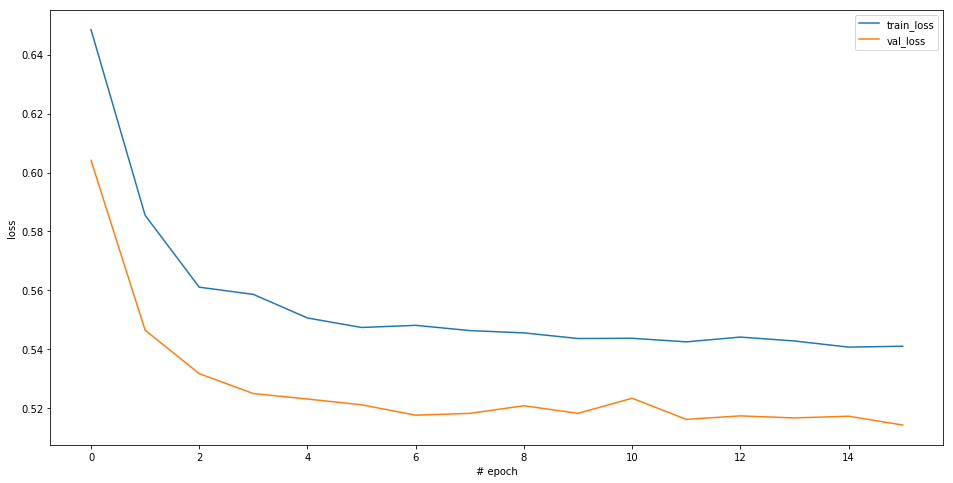

Train loss: 0.541
Val loss: 0.514



HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [360]:
features = torch.from_numpy(df_train_features_extended.values).type(torch.float)
targets = torch.from_numpy(df_train_targets.radiant_win.values.astype('float')).type(torch.FloatTensor)
_, in_size = features.shape
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, TensorDataset(features, targets), train_batch_size=256, val_batch_size=256,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [361]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.814


### Стандартные фичи + вероятность победы на временных фичах

In [40]:
try:
    predictions_logits = torch.load('data_final_predictions_logits.th')
except:
    features, targets = make_features_and_targets_from_file('data_final/train_matches.jsonl')
    model = TimeSeriesPredictor()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    predictions_logits = cross_val_predict(
        model, opt, features, targets, train_batch_size=256, val_batch_size=256,
        callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)])
    torch.save(predictions_logits, 'data_final_predictions_logits.th')

##### Непосредственно временные ряды

In [524]:
time_series_cv_score = roc_auc_score(targets.numpy(), F.sigmoid(predictions_logits).numpy())
print('CV score: {:.3f}'.format(time_series_cv_score))

CV score: 0.792


In [211]:
df_train_features_extended = df_train_features.copy()
add_new_features(df_train_features_extended, predictions_logits=predictions_logits.numpy())

In [516]:
X = df_train_features_extended.values
y = df_train_targets.radiant_win.values.astype('float32')
catboost_clf = catboost.CatBoostClassifier(iterations=500)
catboost_cv_score = cross_val_score(catboost_clf, X, y, scoring='roc_auc')

0:	learn: 0.6844932	total: 220ms	remaining: 1m 49s
1:	learn: 0.6763369	total: 511ms	remaining: 2m 7s
2:	learn: 0.6688492	total: 802ms	remaining: 2m 12s
3:	learn: 0.6618453	total: 1.14s	remaining: 2m 20s
4:	learn: 0.6541946	total: 1.53s	remaining: 2m 31s
5:	learn: 0.6473336	total: 1.79s	remaining: 2m 27s
6:	learn: 0.6408826	total: 2.14s	remaining: 2m 31s
7:	learn: 0.6353978	total: 2.38s	remaining: 2m 26s
8:	learn: 0.6299962	total: 2.66s	remaining: 2m 24s
9:	learn: 0.6253042	total: 2.98s	remaining: 2m 26s
10:	learn: 0.6200976	total: 3.22s	remaining: 2m 23s
11:	learn: 0.6151738	total: 3.56s	remaining: 2m 24s
12:	learn: 0.6114453	total: 3.82s	remaining: 2m 23s
13:	learn: 0.6077355	total: 4.05s	remaining: 2m 20s
14:	learn: 0.6041231	total: 4.41s	remaining: 2m 22s
15:	learn: 0.6001149	total: 4.67s	remaining: 2m 21s
16:	learn: 0.5969907	total: 4.92s	remaining: 2m 19s
17:	learn: 0.5944884	total: 5.24s	remaining: 2m 20s
18:	learn: 0.5921966	total: 5.5s	remaining: 2m 19s
19:	learn: 0.5894536	tot

158:	learn: 0.5213710	total: 43.3s	remaining: 1m 32s
159:	learn: 0.5211912	total: 43.5s	remaining: 1m 32s
160:	learn: 0.5210328	total: 43.8s	remaining: 1m 32s
161:	learn: 0.5208846	total: 44.1s	remaining: 1m 31s
162:	learn: 0.5207712	total: 44.3s	remaining: 1m 31s
163:	learn: 0.5206693	total: 44.5s	remaining: 1m 31s
164:	learn: 0.5205301	total: 44.8s	remaining: 1m 31s
165:	learn: 0.5204123	total: 45.1s	remaining: 1m 30s
166:	learn: 0.5202903	total: 45.4s	remaining: 1m 30s
167:	learn: 0.5202046	total: 45.6s	remaining: 1m 30s
168:	learn: 0.5200737	total: 45.9s	remaining: 1m 29s
169:	learn: 0.5199385	total: 46.2s	remaining: 1m 29s
170:	learn: 0.5197746	total: 46.4s	remaining: 1m 29s
171:	learn: 0.5196486	total: 46.7s	remaining: 1m 29s
172:	learn: 0.5195098	total: 46.9s	remaining: 1m 28s
173:	learn: 0.5194179	total: 47.2s	remaining: 1m 28s
174:	learn: 0.5192524	total: 47.4s	remaining: 1m 28s
175:	learn: 0.5190908	total: 47.6s	remaining: 1m 27s
176:	learn: 0.5189758	total: 47.9s	remaining: 

314:	learn: 0.5051483	total: 1m 23s	remaining: 48.8s
315:	learn: 0.5050271	total: 1m 23s	remaining: 48.6s
316:	learn: 0.5049205	total: 1m 23s	remaining: 48.3s
317:	learn: 0.5048443	total: 1m 24s	remaining: 48.1s
318:	learn: 0.5047349	total: 1m 24s	remaining: 47.8s
319:	learn: 0.5046405	total: 1m 24s	remaining: 47.6s
320:	learn: 0.5045284	total: 1m 24s	remaining: 47.3s
321:	learn: 0.5043979	total: 1m 25s	remaining: 47s
322:	learn: 0.5042775	total: 1m 25s	remaining: 46.7s
323:	learn: 0.5041801	total: 1m 25s	remaining: 46.4s
324:	learn: 0.5040869	total: 1m 25s	remaining: 46.2s
325:	learn: 0.5039889	total: 1m 26s	remaining: 46s
326:	learn: 0.5038885	total: 1m 26s	remaining: 45.7s
327:	learn: 0.5038184	total: 1m 26s	remaining: 45.5s
328:	learn: 0.5036683	total: 1m 27s	remaining: 45.2s
329:	learn: 0.5035159	total: 1m 27s	remaining: 45s
330:	learn: 0.5034132	total: 1m 27s	remaining: 44.7s
331:	learn: 0.5033100	total: 1m 27s	remaining: 44.4s
332:	learn: 0.5032473	total: 1m 28s	remaining: 44.2s

470:	learn: 0.4888346	total: 2m 3s	remaining: 7.62s
471:	learn: 0.4887097	total: 2m 4s	remaining: 7.36s
472:	learn: 0.4885924	total: 2m 4s	remaining: 7.1s
473:	learn: 0.4884680	total: 2m 4s	remaining: 6.84s
474:	learn: 0.4883819	total: 2m 4s	remaining: 6.58s
475:	learn: 0.4882974	total: 2m 5s	remaining: 6.31s
476:	learn: 0.4881584	total: 2m 5s	remaining: 6.04s
477:	learn: 0.4880863	total: 2m 5s	remaining: 5.79s
478:	learn: 0.4879796	total: 2m 5s	remaining: 5.52s
479:	learn: 0.4878714	total: 2m 6s	remaining: 5.26s
480:	learn: 0.4877916	total: 2m 6s	remaining: 5s
481:	learn: 0.4876934	total: 2m 6s	remaining: 4.73s
482:	learn: 0.4875808	total: 2m 6s	remaining: 4.46s
483:	learn: 0.4874745	total: 2m 7s	remaining: 4.2s
484:	learn: 0.4873659	total: 2m 7s	remaining: 3.94s
485:	learn: 0.4872445	total: 2m 7s	remaining: 3.67s
486:	learn: 0.4871541	total: 2m 7s	remaining: 3.41s
487:	learn: 0.4870538	total: 2m 8s	remaining: 3.15s
488:	learn: 0.4869558	total: 2m 8s	remaining: 2.89s
489:	learn: 0.486

129:	learn: 0.5243679	total: 31.5s	remaining: 1m 29s
130:	learn: 0.5242376	total: 31.7s	remaining: 1m 29s
131:	learn: 0.5240910	total: 31.9s	remaining: 1m 29s
132:	learn: 0.5239435	total: 32.2s	remaining: 1m 28s
133:	learn: 0.5237889	total: 32.4s	remaining: 1m 28s
134:	learn: 0.5235806	total: 32.6s	remaining: 1m 28s
135:	learn: 0.5234342	total: 32.9s	remaining: 1m 28s
136:	learn: 0.5232833	total: 33.2s	remaining: 1m 27s
137:	learn: 0.5231938	total: 33.4s	remaining: 1m 27s
138:	learn: 0.5230400	total: 33.5s	remaining: 1m 27s
139:	learn: 0.5228974	total: 33.8s	remaining: 1m 26s
140:	learn: 0.5227154	total: 34s	remaining: 1m 26s
141:	learn: 0.5226239	total: 34.3s	remaining: 1m 26s
142:	learn: 0.5224400	total: 34.6s	remaining: 1m 26s
143:	learn: 0.5223504	total: 34.9s	remaining: 1m 26s
144:	learn: 0.5222170	total: 35.2s	remaining: 1m 26s
145:	learn: 0.5220571	total: 35.4s	remaining: 1m 25s
146:	learn: 0.5218962	total: 35.8s	remaining: 1m 25s
147:	learn: 0.5217315	total: 36.1s	remaining: 1m

286:	learn: 0.5080512	total: 1m 11s	remaining: 53.3s
287:	learn: 0.5079576	total: 1m 11s	remaining: 53s
288:	learn: 0.5078674	total: 1m 12s	remaining: 52.7s
289:	learn: 0.5077759	total: 1m 12s	remaining: 52.5s
290:	learn: 0.5077120	total: 1m 12s	remaining: 52.2s
291:	learn: 0.5076357	total: 1m 12s	remaining: 51.9s
292:	learn: 0.5075518	total: 1m 13s	remaining: 51.8s
293:	learn: 0.5074774	total: 1m 13s	remaining: 51.7s
294:	learn: 0.5073852	total: 1m 14s	remaining: 51.4s
295:	learn: 0.5073168	total: 1m 14s	remaining: 51.2s
296:	learn: 0.5072695	total: 1m 14s	remaining: 50.9s
297:	learn: 0.5071411	total: 1m 14s	remaining: 50.6s
298:	learn: 0.5070493	total: 1m 14s	remaining: 50.4s
299:	learn: 0.5069831	total: 1m 15s	remaining: 50.1s
300:	learn: 0.5069011	total: 1m 15s	remaining: 49.8s
301:	learn: 0.5067783	total: 1m 15s	remaining: 49.5s
302:	learn: 0.5067114	total: 1m 15s	remaining: 49.2s
303:	learn: 0.5065868	total: 1m 15s	remaining: 49s
304:	learn: 0.5065033	total: 1m 16s	remaining: 48.

441:	learn: 0.4936788	total: 1m 49s	remaining: 14.3s
442:	learn: 0.4935790	total: 1m 49s	remaining: 14.1s
443:	learn: 0.4934832	total: 1m 49s	remaining: 13.9s
444:	learn: 0.4933843	total: 1m 50s	remaining: 13.6s
445:	learn: 0.4932965	total: 1m 50s	remaining: 13.4s
446:	learn: 0.4931710	total: 1m 50s	remaining: 13.1s
447:	learn: 0.4930802	total: 1m 50s	remaining: 12.9s
448:	learn: 0.4929741	total: 1m 50s	remaining: 12.6s
449:	learn: 0.4928844	total: 1m 51s	remaining: 12.4s
450:	learn: 0.4927491	total: 1m 51s	remaining: 12.1s
451:	learn: 0.4926692	total: 1m 51s	remaining: 11.9s
452:	learn: 0.4925419	total: 1m 51s	remaining: 11.6s
453:	learn: 0.4924470	total: 1m 52s	remaining: 11.4s
454:	learn: 0.4923760	total: 1m 52s	remaining: 11.1s
455:	learn: 0.4923057	total: 1m 52s	remaining: 10.9s
456:	learn: 0.4922217	total: 1m 52s	remaining: 10.6s
457:	learn: 0.4921209	total: 1m 53s	remaining: 10.4s
458:	learn: 0.4920688	total: 1m 53s	remaining: 10.1s
459:	learn: 0.4919888	total: 1m 53s	remaining:

100:	learn: 0.5281932	total: 27.7s	remaining: 1m 49s
101:	learn: 0.5279706	total: 28s	remaining: 1m 49s
102:	learn: 0.5277568	total: 28.1s	remaining: 1m 48s
103:	learn: 0.5275516	total: 28.4s	remaining: 1m 48s
104:	learn: 0.5273517	total: 28.6s	remaining: 1m 47s
105:	learn: 0.5271541	total: 28.9s	remaining: 1m 47s
106:	learn: 0.5268930	total: 29.1s	remaining: 1m 46s
107:	learn: 0.5267342	total: 29.3s	remaining: 1m 46s
108:	learn: 0.5265560	total: 29.6s	remaining: 1m 46s
109:	learn: 0.5263438	total: 29.8s	remaining: 1m 45s
110:	learn: 0.5261976	total: 30.1s	remaining: 1m 45s
111:	learn: 0.5259553	total: 30.3s	remaining: 1m 44s
112:	learn: 0.5258062	total: 30.5s	remaining: 1m 44s
113:	learn: 0.5256088	total: 30.8s	remaining: 1m 44s
114:	learn: 0.5255178	total: 31.1s	remaining: 1m 44s
115:	learn: 0.5253517	total: 31.4s	remaining: 1m 43s
116:	learn: 0.5251618	total: 31.6s	remaining: 1m 43s
117:	learn: 0.5248928	total: 31.9s	remaining: 1m 43s
118:	learn: 0.5247599	total: 32.1s	remaining: 1m

256:	learn: 0.5088538	total: 1m 7s	remaining: 1m 4s
257:	learn: 0.5087334	total: 1m 8s	remaining: 1m 3s
258:	learn: 0.5086489	total: 1m 8s	remaining: 1m 3s
259:	learn: 0.5085230	total: 1m 8s	remaining: 1m 3s
260:	learn: 0.5084339	total: 1m 8s	remaining: 1m 3s
261:	learn: 0.5083842	total: 1m 9s	remaining: 1m 2s
262:	learn: 0.5082837	total: 1m 9s	remaining: 1m 2s
263:	learn: 0.5082037	total: 1m 9s	remaining: 1m 2s
264:	learn: 0.5081108	total: 1m 9s	remaining: 1m 1s
265:	learn: 0.5080503	total: 1m 9s	remaining: 1m 1s
266:	learn: 0.5079776	total: 1m 10s	remaining: 1m 1s
267:	learn: 0.5078726	total: 1m 10s	remaining: 1m
268:	learn: 0.5077387	total: 1m 10s	remaining: 1m
269:	learn: 0.5076604	total: 1m 10s	remaining: 1m
270:	learn: 0.5075990	total: 1m 11s	remaining: 1m
271:	learn: 0.5074914	total: 1m 11s	remaining: 59.8s
272:	learn: 0.5073934	total: 1m 11s	remaining: 59.6s
273:	learn: 0.5073240	total: 1m 11s	remaining: 59.3s
274:	learn: 0.5072403	total: 1m 12s	remaining: 59s
275:	learn: 0.507

412:	learn: 0.4938610	total: 1m 48s	remaining: 23s
413:	learn: 0.4937964	total: 1m 49s	remaining: 22.7s
414:	learn: 0.4937238	total: 1m 49s	remaining: 22.4s
415:	learn: 0.4935797	total: 1m 49s	remaining: 22.2s
416:	learn: 0.4935096	total: 1m 50s	remaining: 21.9s
417:	learn: 0.4934048	total: 1m 50s	remaining: 21.6s
418:	learn: 0.4932957	total: 1m 50s	remaining: 21.4s
419:	learn: 0.4931932	total: 1m 50s	remaining: 21.1s
420:	learn: 0.4930701	total: 1m 51s	remaining: 20.8s
421:	learn: 0.4929816	total: 1m 51s	remaining: 20.6s
422:	learn: 0.4928631	total: 1m 51s	remaining: 20.3s
423:	learn: 0.4927695	total: 1m 51s	remaining: 20s
424:	learn: 0.4926689	total: 1m 52s	remaining: 19.8s
425:	learn: 0.4925763	total: 1m 52s	remaining: 19.5s
426:	learn: 0.4925071	total: 1m 52s	remaining: 19.2s
427:	learn: 0.4924074	total: 1m 52s	remaining: 19s
428:	learn: 0.4922951	total: 1m 53s	remaining: 18.7s
429:	learn: 0.4922022	total: 1m 53s	remaining: 18.4s
430:	learn: 0.4921180	total: 1m 53s	remaining: 18.2s

In [517]:
print('CV score: {:.3f}'.format(catboost_cv_score.mean()))

CV score: 0.809


##### NN

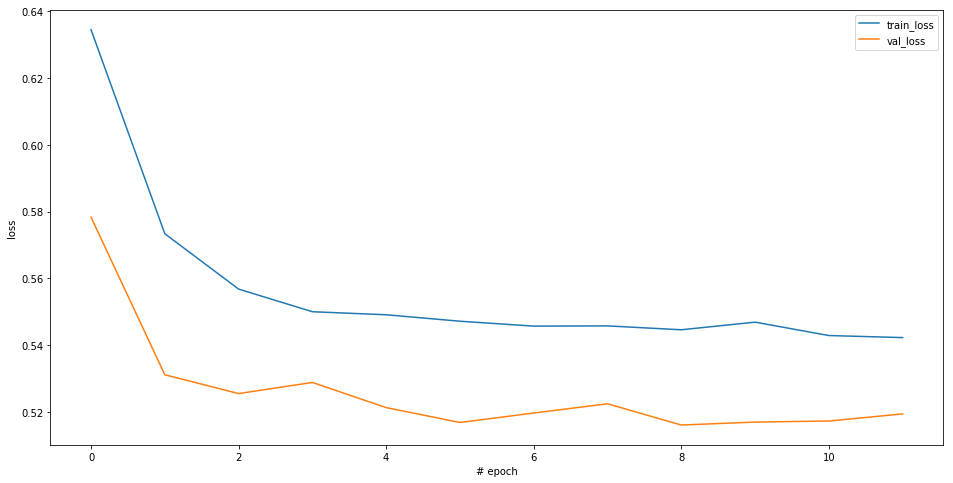

Train loss: 0.542
Val loss: 0.519



HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [358]:
features = torch.from_numpy(df_train_features_extended.values).type(torch.float)
targets = torch.from_numpy(df_train_targets.radiant_win.values.astype('float')).type(torch.FloatTensor)
_, in_size = features.shape
model = WinRatePredictor(in_size, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, TensorDataset(features, targets), train_batch_size=256, val_batch_size=256,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [359]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.811


##### NN end-to-end

In [41]:
try:
    time_series = torch.load('data_final_time_series.th')
except:
    time_series = make_time_series_features_from_file('data_final/train_matches.jsonl')
    torch.save(time_series, 'data_final_time_series.th')

In [367]:
features = torch.from_numpy(df_train_features.values).type(torch.FloatTensor)
picks = torch.from_numpy(picks_dense).type(torch.FloatTensor)
targets = torch.from_numpy(df_train_targets['radiant_win'].values.astype('float')).type(torch.FloatTensor)
dataset = TensorDataset(features, picks, time_series, targets)

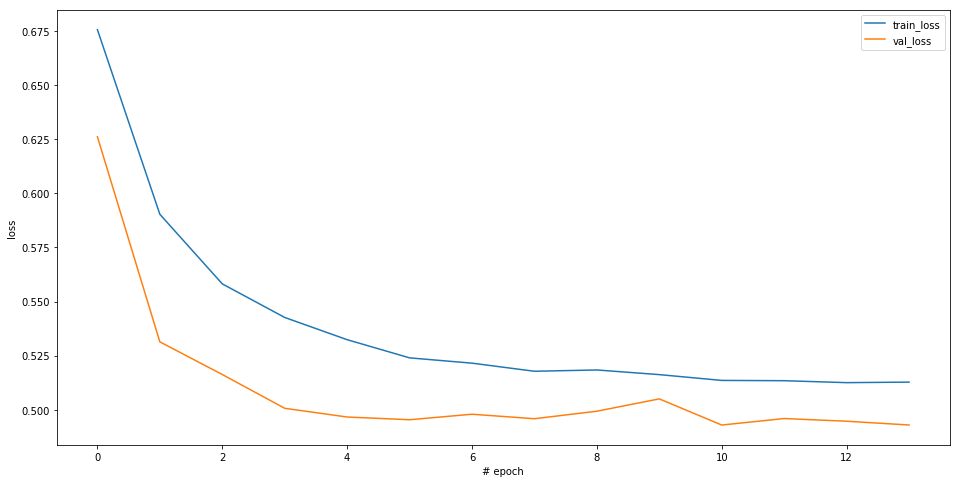

Train loss: 0.513
Val loss: 0.493



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

In [371]:
_, n_features = features.shape
_, n_heroes = picks.shape
*_, n_time_series_channels = time_series.shape
model = MultiInputPredictor(n_features, n_heroes, n_time_series_channels)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, dataset, train_batch_size=512, val_batch_size=512,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [372]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.836


# Next Roshan predict

### Пики

### CatBoost

In [544]:
X = picks_dense
y = df_train_targets['next_roshan_team'].map(lambda x: make_roshan_target(x)).values.astype('float32')
catboost_clf = catboost.CatBoostClassifier(iterations=500, loss_function='MultiClass')
catboost_cv_score = cross_val_score(catboost_clf, X, y, scoring='neg_log_loss')

0:	learn: -1.0975395	total: 222ms	remaining: 1m 50s
1:	learn: -1.0964881	total: 632ms	remaining: 2m 37s
2:	learn: -1.0955195	total: 835ms	remaining: 2m 18s
3:	learn: -1.0948954	total: 1.22s	remaining: 2m 31s
4:	learn: -1.0940359	total: 1.59s	remaining: 2m 37s
5:	learn: -1.0932270	total: 1.85s	remaining: 2m 32s
6:	learn: -1.0924627	total: 2.27s	remaining: 2m 39s
7:	learn: -1.0917456	total: 2.66s	remaining: 2m 43s
8:	learn: -1.0911826	total: 2.96s	remaining: 2m 41s
9:	learn: -1.0906542	total: 3.38s	remaining: 2m 45s
10:	learn: -1.0900380	total: 3.63s	remaining: 2m 41s
11:	learn: -1.0894511	total: 3.93s	remaining: 2m 39s
12:	learn: -1.0888892	total: 4.23s	remaining: 2m 38s
13:	learn: -1.0884130	total: 4.56s	remaining: 2m 38s
14:	learn: -1.0879145	total: 4.85s	remaining: 2m 36s
15:	learn: -1.0875828	total: 5.13s	remaining: 2m 35s
16:	learn: -1.0871950	total: 5.37s	remaining: 2m 32s
17:	learn: -1.0867604	total: 5.7s	remaining: 2m 32s
18:	learn: -1.0863328	total: 5.97s	remaining: 2m 31s
19:	

156:	learn: -1.0672047	total: 47.4s	remaining: 1m 43s
157:	learn: -1.0671313	total: 47.8s	remaining: 1m 43s
158:	learn: -1.0670608	total: 48.1s	remaining: 1m 43s
159:	learn: -1.0669571	total: 48.4s	remaining: 1m 42s
160:	learn: -1.0668761	total: 48.6s	remaining: 1m 42s
161:	learn: -1.0667907	total: 48.9s	remaining: 1m 41s
162:	learn: -1.0666932	total: 49.2s	remaining: 1m 41s
163:	learn: -1.0666125	total: 49.5s	remaining: 1m 41s
164:	learn: -1.0665290	total: 49.8s	remaining: 1m 41s
165:	learn: -1.0664547	total: 50.1s	remaining: 1m 40s
166:	learn: -1.0663549	total: 50.4s	remaining: 1m 40s
167:	learn: -1.0662446	total: 50.7s	remaining: 1m 40s
168:	learn: -1.0661978	total: 51s	remaining: 1m 39s
169:	learn: -1.0661145	total: 51.3s	remaining: 1m 39s
170:	learn: -1.0660182	total: 51.7s	remaining: 1m 39s
171:	learn: -1.0659292	total: 51.9s	remaining: 1m 39s
172:	learn: -1.0658545	total: 52.2s	remaining: 1m 38s
173:	learn: -1.0657599	total: 52.6s	remaining: 1m 38s
174:	learn: -1.0656754	total: 

308:	learn: -1.0557217	total: 1m 33s	remaining: 58s
309:	learn: -1.0556376	total: 1m 34s	remaining: 57.7s
310:	learn: -1.0555664	total: 1m 34s	remaining: 57.4s
311:	learn: -1.0554927	total: 1m 34s	remaining: 57.1s
312:	learn: -1.0554100	total: 1m 35s	remaining: 56.8s
313:	learn: -1.0553474	total: 1m 35s	remaining: 56.5s
314:	learn: -1.0552844	total: 1m 35s	remaining: 56.2s
315:	learn: -1.0551974	total: 1m 35s	remaining: 55.9s
316:	learn: -1.0551239	total: 1m 36s	remaining: 55.6s
317:	learn: -1.0550588	total: 1m 36s	remaining: 55.2s
318:	learn: -1.0549944	total: 1m 36s	remaining: 55s
319:	learn: -1.0549163	total: 1m 37s	remaining: 54.7s
320:	learn: -1.0548290	total: 1m 37s	remaining: 54.4s
321:	learn: -1.0547651	total: 1m 37s	remaining: 54s
322:	learn: -1.0547296	total: 1m 38s	remaining: 53.7s
323:	learn: -1.0546549	total: 1m 38s	remaining: 53.4s
324:	learn: -1.0545820	total: 1m 38s	remaining: 53.1s
325:	learn: -1.0545177	total: 1m 38s	remaining: 52.8s
326:	learn: -1.0544531	total: 1m 3

462:	learn: -1.0444680	total: 2m 19s	remaining: 11.2s
463:	learn: -1.0443939	total: 2m 20s	remaining: 10.9s
464:	learn: -1.0443235	total: 2m 20s	remaining: 10.6s
465:	learn: -1.0442699	total: 2m 20s	remaining: 10.3s
466:	learn: -1.0442161	total: 2m 21s	remaining: 9.97s
467:	learn: -1.0441365	total: 2m 21s	remaining: 9.67s
468:	learn: -1.0440529	total: 2m 21s	remaining: 9.37s
469:	learn: -1.0439878	total: 2m 22s	remaining: 9.07s
470:	learn: -1.0439253	total: 2m 22s	remaining: 8.76s
471:	learn: -1.0438591	total: 2m 22s	remaining: 8.46s
472:	learn: -1.0437669	total: 2m 22s	remaining: 8.16s
473:	learn: -1.0436880	total: 2m 23s	remaining: 7.86s
474:	learn: -1.0436060	total: 2m 23s	remaining: 7.56s
475:	learn: -1.0435225	total: 2m 23s	remaining: 7.25s
476:	learn: -1.0434587	total: 2m 24s	remaining: 6.95s
477:	learn: -1.0433843	total: 2m 24s	remaining: 6.65s
478:	learn: -1.0433247	total: 2m 24s	remaining: 6.35s
479:	learn: -1.0432568	total: 2m 25s	remaining: 6.04s
480:	learn: -1.0431927	total

118:	learn: -1.0725648	total: 33.9s	remaining: 1m 48s
119:	learn: -1.0724593	total: 34.2s	remaining: 1m 48s
120:	learn: -1.0723795	total: 34.4s	remaining: 1m 47s
121:	learn: -1.0723181	total: 34.7s	remaining: 1m 47s
122:	learn: -1.0722387	total: 35s	remaining: 1m 47s
123:	learn: -1.0721452	total: 35.5s	remaining: 1m 47s
124:	learn: -1.0720340	total: 35.8s	remaining: 1m 47s
125:	learn: -1.0719343	total: 36.2s	remaining: 1m 47s
126:	learn: -1.0718440	total: 36.5s	remaining: 1m 47s
127:	learn: -1.0717549	total: 36.8s	remaining: 1m 46s
128:	learn: -1.0716702	total: 37.1s	remaining: 1m 46s
129:	learn: -1.0715968	total: 37.4s	remaining: 1m 46s
130:	learn: -1.0715302	total: 37.7s	remaining: 1m 46s
131:	learn: -1.0714591	total: 37.9s	remaining: 1m 45s
132:	learn: -1.0713809	total: 38.3s	remaining: 1m 45s
133:	learn: -1.0712985	total: 38.7s	remaining: 1m 45s
134:	learn: -1.0711980	total: 39s	remaining: 1m 45s
135:	learn: -1.0711210	total: 39.4s	remaining: 1m 45s
136:	learn: -1.0710236	total: 39

270:	learn: -1.0610472	total: 1m 19s	remaining: 1m 7s
271:	learn: -1.0609787	total: 1m 20s	remaining: 1m 7s
272:	learn: -1.0609305	total: 1m 20s	remaining: 1m 7s
273:	learn: -1.0608639	total: 1m 20s	remaining: 1m 6s
274:	learn: -1.0607723	total: 1m 21s	remaining: 1m 6s
275:	learn: -1.0606683	total: 1m 21s	remaining: 1m 6s
276:	learn: -1.0605888	total: 1m 21s	remaining: 1m 5s
277:	learn: -1.0605202	total: 1m 22s	remaining: 1m 5s
278:	learn: -1.0604468	total: 1m 22s	remaining: 1m 5s
279:	learn: -1.0603823	total: 1m 22s	remaining: 1m 5s
280:	learn: -1.0603296	total: 1m 23s	remaining: 1m 4s
281:	learn: -1.0602516	total: 1m 23s	remaining: 1m 4s
282:	learn: -1.0602172	total: 1m 23s	remaining: 1m 4s
283:	learn: -1.0601422	total: 1m 24s	remaining: 1m 3s
284:	learn: -1.0600823	total: 1m 24s	remaining: 1m 3s
285:	learn: -1.0600236	total: 1m 24s	remaining: 1m 3s
286:	learn: -1.0599568	total: 1m 25s	remaining: 1m 3s
287:	learn: -1.0598911	total: 1m 25s	remaining: 1m 2s
288:	learn: -1.0598265	total

423:	learn: -1.0504518	total: 2m 7s	remaining: 22.9s
424:	learn: -1.0503753	total: 2m 8s	remaining: 22.6s
425:	learn: -1.0503157	total: 2m 8s	remaining: 22.3s
426:	learn: -1.0502487	total: 2m 8s	remaining: 22s
427:	learn: -1.0501781	total: 2m 8s	remaining: 21.7s
428:	learn: -1.0501096	total: 2m 9s	remaining: 21.4s
429:	learn: -1.0500246	total: 2m 9s	remaining: 21.1s
430:	learn: -1.0499577	total: 2m 9s	remaining: 20.8s
431:	learn: -1.0498982	total: 2m 10s	remaining: 20.5s
432:	learn: -1.0498361	total: 2m 10s	remaining: 20.2s
433:	learn: -1.0497880	total: 2m 10s	remaining: 19.9s
434:	learn: -1.0497196	total: 2m 11s	remaining: 19.6s
435:	learn: -1.0496427	total: 2m 11s	remaining: 19.3s
436:	learn: -1.0495790	total: 2m 11s	remaining: 19s
437:	learn: -1.0494962	total: 2m 11s	remaining: 18.7s
438:	learn: -1.0494398	total: 2m 12s	remaining: 18.4s
439:	learn: -1.0493565	total: 2m 12s	remaining: 18.1s
440:	learn: -1.0493024	total: 2m 13s	remaining: 17.8s
441:	learn: -1.0492422	total: 2m 13s	rem

77:	learn: -1.0765432	total: 24s	remaining: 2m 9s
78:	learn: -1.0764262	total: 24.2s	remaining: 2m 8s
79:	learn: -1.0763017	total: 24.6s	remaining: 2m 8s
80:	learn: -1.0762060	total: 24.9s	remaining: 2m 8s
81:	learn: -1.0761279	total: 25.2s	remaining: 2m 8s
82:	learn: -1.0760284	total: 25.5s	remaining: 2m 8s
83:	learn: -1.0759168	total: 25.8s	remaining: 2m 7s
84:	learn: -1.0758263	total: 26.1s	remaining: 2m 7s
85:	learn: -1.0757011	total: 26.4s	remaining: 2m 7s
86:	learn: -1.0755831	total: 26.7s	remaining: 2m 6s
87:	learn: -1.0754541	total: 27.1s	remaining: 2m 6s
88:	learn: -1.0753095	total: 27.4s	remaining: 2m 6s
89:	learn: -1.0751815	total: 27.7s	remaining: 2m 6s
90:	learn: -1.0750516	total: 28.1s	remaining: 2m 6s
91:	learn: -1.0749163	total: 28.4s	remaining: 2m 5s
92:	learn: -1.0748314	total: 28.7s	remaining: 2m 5s
93:	learn: -1.0747200	total: 29s	remaining: 2m 5s
94:	learn: -1.0746178	total: 29.3s	remaining: 2m 5s
95:	learn: -1.0745149	total: 29.6s	remaining: 2m 4s
96:	learn: -1.07

231:	learn: -1.0630529	total: 1m 10s	remaining: 1m 21s
232:	learn: -1.0629596	total: 1m 11s	remaining: 1m 21s
233:	learn: -1.0628771	total: 1m 11s	remaining: 1m 21s
234:	learn: -1.0628213	total: 1m 11s	remaining: 1m 20s
235:	learn: -1.0627406	total: 1m 11s	remaining: 1m 20s
236:	learn: -1.0626793	total: 1m 12s	remaining: 1m 20s
237:	learn: -1.0626107	total: 1m 12s	remaining: 1m 19s
238:	learn: -1.0625505	total: 1m 12s	remaining: 1m 19s
239:	learn: -1.0624843	total: 1m 13s	remaining: 1m 19s
240:	learn: -1.0624114	total: 1m 13s	remaining: 1m 19s
241:	learn: -1.0623193	total: 1m 14s	remaining: 1m 18s
242:	learn: -1.0622450	total: 1m 14s	remaining: 1m 18s
243:	learn: -1.0621681	total: 1m 14s	remaining: 1m 18s
244:	learn: -1.0621009	total: 1m 15s	remaining: 1m 18s
245:	learn: -1.0620273	total: 1m 15s	remaining: 1m 17s
246:	learn: -1.0619491	total: 1m 15s	remaining: 1m 17s
247:	learn: -1.0618805	total: 1m 15s	remaining: 1m 17s
248:	learn: -1.0618055	total: 1m 16s	remaining: 1m 16s
249:	learn

383:	learn: -1.0521382	total: 1m 57s	remaining: 35.6s
384:	learn: -1.0520748	total: 1m 58s	remaining: 35.3s
385:	learn: -1.0519762	total: 1m 58s	remaining: 34.9s
386:	learn: -1.0519079	total: 1m 58s	remaining: 34.6s
387:	learn: -1.0518365	total: 1m 58s	remaining: 34.3s
388:	learn: -1.0517589	total: 1m 59s	remaining: 34s
389:	learn: -1.0516765	total: 1m 59s	remaining: 33.7s
390:	learn: -1.0515860	total: 1m 59s	remaining: 33.4s
391:	learn: -1.0515155	total: 2m	remaining: 33.1s
392:	learn: -1.0514622	total: 2m	remaining: 32.8s
393:	learn: -1.0514063	total: 2m	remaining: 32.5s
394:	learn: -1.0513247	total: 2m 1s	remaining: 32.2s
395:	learn: -1.0512471	total: 2m 1s	remaining: 31.9s
396:	learn: -1.0511779	total: 2m 1s	remaining: 31.6s
397:	learn: -1.0510917	total: 2m 2s	remaining: 31.3s
398:	learn: -1.0510216	total: 2m 2s	remaining: 31s
399:	learn: -1.0509456	total: 2m 2s	remaining: 30.7s
400:	learn: -1.0508646	total: 2m 3s	remaining: 30.4s
401:	learn: -1.0508021	total: 2m 3s	remaining: 30.1

In [545]:
print('CV score: {:.3f}'.format(catboost_cv_score.mean()))

CV score: -1.069


### Стандартные фичи

##### CatBoost

In [89]:
X = df_train_features.values
y = df_train_targets['next_roshan_team'].map(lambda x: make_roshan_target(x)).values.astype('float32')
catboost_clf = catboost.CatBoostClassifier(iterations=500, loss_function='MultiClass')
catboost_cv_score = cross_val_score(catboost_clf, X, y, scoring='f1_macro')

0:	learn: -1.0959624	total: 652ms	remaining: 5m 25s
1:	learn: -1.0933352	total: 1.02s	remaining: 4m 14s
2:	learn: -1.0911761	total: 1.33s	remaining: 3m 39s
3:	learn: -1.0890891	total: 1.62s	remaining: 3m 20s
4:	learn: -1.0870162	total: 2.06s	remaining: 3m 23s
5:	learn: -1.0853953	total: 2.33s	remaining: 3m 11s
6:	learn: -1.0836411	total: 2.77s	remaining: 3m 15s
7:	learn: -1.0817643	total: 2.97s	remaining: 3m 2s
8:	learn: -1.0799750	total: 3.35s	remaining: 3m 2s
9:	learn: -1.0784345	total: 3.58s	remaining: 2m 55s
10:	learn: -1.0767505	total: 3.88s	remaining: 2m 52s
11:	learn: -1.0750155	total: 4.33s	remaining: 2m 55s
12:	learn: -1.0736295	total: 4.63s	remaining: 2m 53s
13:	learn: -1.0720266	total: 4.96s	remaining: 2m 52s
14:	learn: -1.0708488	total: 5.16s	remaining: 2m 46s
15:	learn: -1.0696034	total: 5.51s	remaining: 2m 46s
16:	learn: -1.0682826	total: 5.81s	remaining: 2m 45s
17:	learn: -1.0670660	total: 6.25s	remaining: 2m 47s
18:	learn: -1.0658862	total: 6.56s	remaining: 2m 46s
19:	l

155:	learn: -1.0076081	total: 49s	remaining: 1m 47s
156:	learn: -1.0074962	total: 49.3s	remaining: 1m 47s
157:	learn: -1.0072361	total: 49.6s	remaining: 1m 47s
158:	learn: -1.0070292	total: 49.9s	remaining: 1m 46s
159:	learn: -1.0067934	total: 50.1s	remaining: 1m 46s
160:	learn: -1.0066239	total: 50.5s	remaining: 1m 46s
161:	learn: -1.0063969	total: 50.7s	remaining: 1m 45s
162:	learn: -1.0062666	total: 51.1s	remaining: 1m 45s
163:	learn: -1.0061181	total: 51.4s	remaining: 1m 45s
164:	learn: -1.0058959	total: 51.6s	remaining: 1m 44s
165:	learn: -1.0056884	total: 51.9s	remaining: 1m 44s
166:	learn: -1.0053901	total: 52.2s	remaining: 1m 44s
167:	learn: -1.0051463	total: 52.5s	remaining: 1m 43s
168:	learn: -1.0050032	total: 52.9s	remaining: 1m 43s
169:	learn: -1.0048305	total: 53.2s	remaining: 1m 43s
170:	learn: -1.0046880	total: 53.4s	remaining: 1m 42s
171:	learn: -1.0044919	total: 53.7s	remaining: 1m 42s
172:	learn: -1.0043270	total: 53.9s	remaining: 1m 41s
173:	learn: -1.0040787	total: 

307:	learn: -0.9831156	total: 1m 32s	remaining: 57.4s
308:	learn: -0.9829829	total: 1m 32s	remaining: 57s
309:	learn: -0.9827912	total: 1m 32s	remaining: 56.8s
310:	learn: -0.9826269	total: 1m 32s	remaining: 56.5s
311:	learn: -0.9825075	total: 1m 33s	remaining: 56.1s
312:	learn: -0.9823145	total: 1m 33s	remaining: 55.8s
313:	learn: -0.9821539	total: 1m 33s	remaining: 55.4s
314:	learn: -0.9820143	total: 1m 33s	remaining: 55.1s
315:	learn: -0.9819365	total: 1m 34s	remaining: 54.8s
316:	learn: -0.9817882	total: 1m 34s	remaining: 54.5s
317:	learn: -0.9816283	total: 1m 34s	remaining: 54.2s
318:	learn: -0.9815431	total: 1m 34s	remaining: 53.9s
319:	learn: -0.9814530	total: 1m 35s	remaining: 53.6s
320:	learn: -0.9813146	total: 1m 35s	remaining: 53.3s
321:	learn: -0.9811881	total: 1m 35s	remaining: 52.9s
322:	learn: -0.9810139	total: 1m 36s	remaining: 52.6s
323:	learn: -0.9808282	total: 1m 36s	remaining: 52.4s
324:	learn: -0.9806970	total: 1m 36s	remaining: 52.1s
325:	learn: -0.9805041	total: 

461:	learn: -0.9580515	total: 2m 16s	remaining: 11.2s
462:	learn: -0.9579168	total: 2m 16s	remaining: 10.9s
463:	learn: -0.9577697	total: 2m 17s	remaining: 10.6s
464:	learn: -0.9575468	total: 2m 17s	remaining: 10.3s
465:	learn: -0.9573870	total: 2m 17s	remaining: 10.1s
466:	learn: -0.9573008	total: 2m 17s	remaining: 9.75s
467:	learn: -0.9571182	total: 2m 18s	remaining: 9.45s
468:	learn: -0.9570153	total: 2m 18s	remaining: 9.16s
469:	learn: -0.9568662	total: 2m 18s	remaining: 8.86s
470:	learn: -0.9567403	total: 2m 19s	remaining: 8.56s
471:	learn: -0.9565716	total: 2m 19s	remaining: 8.27s
472:	learn: -0.9564012	total: 2m 19s	remaining: 7.97s
473:	learn: -0.9561964	total: 2m 19s	remaining: 7.67s
474:	learn: -0.9560240	total: 2m 20s	remaining: 7.38s
475:	learn: -0.9558697	total: 2m 20s	remaining: 7.08s
476:	learn: -0.9557959	total: 2m 20s	remaining: 6.79s
477:	learn: -0.9556273	total: 2m 21s	remaining: 6.49s
478:	learn: -0.9555061	total: 2m 21s	remaining: 6.2s
479:	learn: -0.9553920	total:

116:	learn: -1.0146758	total: 34.2s	remaining: 1m 51s
117:	learn: -1.0143032	total: 34.5s	remaining: 1m 51s
118:	learn: -1.0140757	total: 34.8s	remaining: 1m 51s
119:	learn: -1.0137906	total: 35.1s	remaining: 1m 51s
120:	learn: -1.0135700	total: 35.4s	remaining: 1m 50s
121:	learn: -1.0133254	total: 35.7s	remaining: 1m 50s
122:	learn: -1.0131005	total: 36.1s	remaining: 1m 50s
123:	learn: -1.0127731	total: 36.4s	remaining: 1m 50s
124:	learn: -1.0125361	total: 36.7s	remaining: 1m 50s
125:	learn: -1.0123203	total: 37s	remaining: 1m 49s
126:	learn: -1.0121665	total: 37.3s	remaining: 1m 49s
127:	learn: -1.0119392	total: 37.6s	remaining: 1m 49s
128:	learn: -1.0117044	total: 37.9s	remaining: 1m 48s
129:	learn: -1.0113316	total: 38.1s	remaining: 1m 48s
130:	learn: -1.0111122	total: 38.4s	remaining: 1m 48s
131:	learn: -1.0109213	total: 38.7s	remaining: 1m 47s
132:	learn: -1.0106615	total: 39s	remaining: 1m 47s
133:	learn: -1.0104646	total: 39.3s	remaining: 1m 47s
134:	learn: -1.0101446	total: 39

269:	learn: -0.9845064	total: 1m 16s	remaining: 1m 5s
270:	learn: -0.9843574	total: 1m 16s	remaining: 1m 4s
271:	learn: -0.9842315	total: 1m 17s	remaining: 1m 4s
272:	learn: -0.9841295	total: 1m 17s	remaining: 1m 4s
273:	learn: -0.9840539	total: 1m 17s	remaining: 1m 4s
274:	learn: -0.9839197	total: 1m 17s	remaining: 1m 3s
275:	learn: -0.9837877	total: 1m 18s	remaining: 1m 3s
276:	learn: -0.9836955	total: 1m 18s	remaining: 1m 3s
277:	learn: -0.9835585	total: 1m 18s	remaining: 1m 2s
278:	learn: -0.9833371	total: 1m 19s	remaining: 1m 2s
279:	learn: -0.9832102	total: 1m 19s	remaining: 1m 2s
280:	learn: -0.9830700	total: 1m 19s	remaining: 1m 2s
281:	learn: -0.9828630	total: 1m 19s	remaining: 1m 1s
282:	learn: -0.9826627	total: 1m 20s	remaining: 1m 1s
283:	learn: -0.9825194	total: 1m 20s	remaining: 1m 1s
284:	learn: -0.9823923	total: 1m 20s	remaining: 1m
285:	learn: -0.9821770	total: 1m 20s	remaining: 1m
286:	learn: -0.9819425	total: 1m 21s	remaining: 1m
287:	learn: -0.9817619	total: 1m 21s	

422:	learn: -0.9602592	total: 1m 57s	remaining: 21.3s
423:	learn: -0.9600762	total: 1m 57s	remaining: 21.1s
424:	learn: -0.9598969	total: 1m 57s	remaining: 20.8s
425:	learn: -0.9597832	total: 1m 58s	remaining: 20.5s
426:	learn: -0.9596540	total: 1m 58s	remaining: 20.2s
427:	learn: -0.9594931	total: 1m 58s	remaining: 19.9s
428:	learn: -0.9593353	total: 1m 58s	remaining: 19.7s
429:	learn: -0.9591486	total: 1m 59s	remaining: 19.4s
430:	learn: -0.9589911	total: 1m 59s	remaining: 19.1s
431:	learn: -0.9587728	total: 1m 59s	remaining: 18.8s
432:	learn: -0.9585844	total: 1m 59s	remaining: 18.5s
433:	learn: -0.9584488	total: 2m	remaining: 18.3s
434:	learn: -0.9582637	total: 2m	remaining: 18s
435:	learn: -0.9580420	total: 2m	remaining: 17.7s
436:	learn: -0.9579143	total: 2m	remaining: 17.4s
437:	learn: -0.9577562	total: 2m 1s	remaining: 17.2s
438:	learn: -0.9575203	total: 2m 1s	remaining: 16.9s
439:	learn: -0.9573357	total: 2m 1s	remaining: 16.6s
440:	learn: -0.9571017	total: 2m 2s	remaining: 16

78:	learn: -1.0281936	total: 22.6s	remaining: 2m
79:	learn: -1.0277584	total: 22.8s	remaining: 1m 59s
80:	learn: -1.0272755	total: 23.1s	remaining: 1m 59s
81:	learn: -1.0268054	total: 23.3s	remaining: 1m 58s
82:	learn: -1.0264622	total: 23.6s	remaining: 1m 58s
83:	learn: -1.0260978	total: 23.9s	remaining: 1m 58s
84:	learn: -1.0257392	total: 24.1s	remaining: 1m 57s
85:	learn: -1.0254857	total: 24.3s	remaining: 1m 57s
86:	learn: -1.0251535	total: 24.7s	remaining: 1m 57s
87:	learn: -1.0247086	total: 24.9s	remaining: 1m 56s
88:	learn: -1.0242847	total: 25.1s	remaining: 1m 55s
89:	learn: -1.0239548	total: 25.4s	remaining: 1m 55s
90:	learn: -1.0235521	total: 25.7s	remaining: 1m 55s
91:	learn: -1.0231747	total: 25.9s	remaining: 1m 54s
92:	learn: -1.0229273	total: 26.1s	remaining: 1m 54s
93:	learn: -1.0225814	total: 26.4s	remaining: 1m 54s
94:	learn: -1.0223496	total: 26.6s	remaining: 1m 53s
95:	learn: -1.0219599	total: 26.9s	remaining: 1m 53s
96:	learn: -1.0217055	total: 27.2s	remaining: 1m 5

231:	learn: -0.9920943	total: 1m 3s	remaining: 1m 13s
232:	learn: -0.9919558	total: 1m 4s	remaining: 1m 13s
233:	learn: -0.9918429	total: 1m 4s	remaining: 1m 13s
234:	learn: -0.9916035	total: 1m 4s	remaining: 1m 13s
235:	learn: -0.9914323	total: 1m 5s	remaining: 1m 12s
236:	learn: -0.9913160	total: 1m 5s	remaining: 1m 12s
237:	learn: -0.9911307	total: 1m 5s	remaining: 1m 12s
238:	learn: -0.9908675	total: 1m 5s	remaining: 1m 11s
239:	learn: -0.9907725	total: 1m 6s	remaining: 1m 11s
240:	learn: -0.9905534	total: 1m 6s	remaining: 1m 11s
241:	learn: -0.9903916	total: 1m 6s	remaining: 1m 11s
242:	learn: -0.9902671	total: 1m 6s	remaining: 1m 10s
243:	learn: -0.9901759	total: 1m 7s	remaining: 1m 10s
244:	learn: -0.9900106	total: 1m 7s	remaining: 1m 10s
245:	learn: -0.9899038	total: 1m 7s	remaining: 1m 9s
246:	learn: -0.9896296	total: 1m 7s	remaining: 1m 9s
247:	learn: -0.9894739	total: 1m 8s	remaining: 1m 9s
248:	learn: -0.9893193	total: 1m 8s	remaining: 1m 9s
249:	learn: -0.9892037	total: 1m

384:	learn: -0.9686975	total: 1m 45s	remaining: 31.4s
385:	learn: -0.9685883	total: 1m 45s	remaining: 31.2s
386:	learn: -0.9684492	total: 1m 45s	remaining: 30.9s
387:	learn: -0.9682065	total: 1m 46s	remaining: 30.6s
388:	learn: -0.9680569	total: 1m 46s	remaining: 30.3s
389:	learn: -0.9679526	total: 1m 46s	remaining: 30s
390:	learn: -0.9677876	total: 1m 46s	remaining: 29.8s
391:	learn: -0.9676156	total: 1m 47s	remaining: 29.5s
392:	learn: -0.9675322	total: 1m 47s	remaining: 29.2s
393:	learn: -0.9674074	total: 1m 47s	remaining: 28.9s
394:	learn: -0.9672624	total: 1m 47s	remaining: 28.7s
395:	learn: -0.9670104	total: 1m 48s	remaining: 28.4s
396:	learn: -0.9668357	total: 1m 48s	remaining: 28.1s
397:	learn: -0.9666463	total: 1m 48s	remaining: 27.9s
398:	learn: -0.9665193	total: 1m 48s	remaining: 27.6s
399:	learn: -0.9663163	total: 1m 49s	remaining: 27.3s
400:	learn: -0.9661398	total: 1m 49s	remaining: 27s
401:	learn: -0.9659717	total: 1m 49s	remaining: 26.7s
402:	learn: -0.9658122	total: 1m

In [90]:
print('CV score: {:.3f}'.format(catboost_cv_score.mean()))

CV score: 0.480


In [42]:
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

##### NN

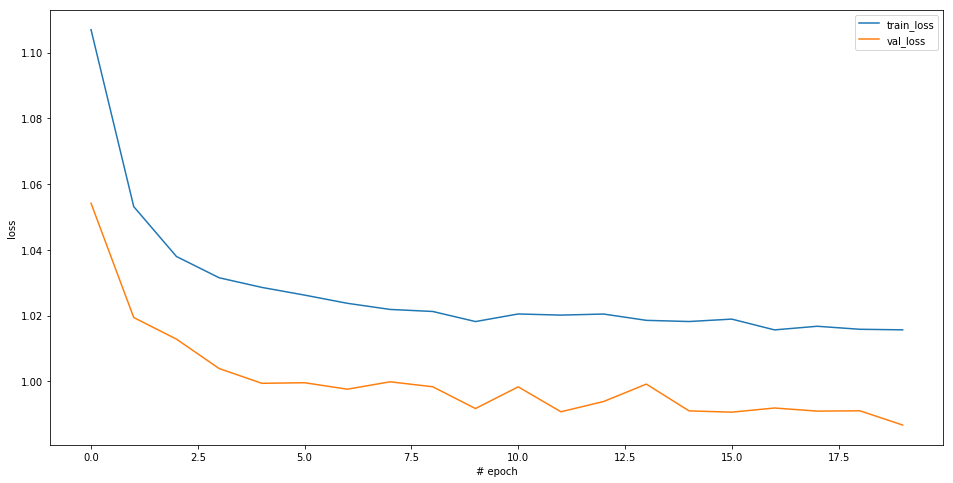

Train loss: 1.016
Val loss: 0.987



HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

In [375]:
features = torch.from_numpy(df_train_features.values).type(torch.float)
targets = df_train_targets.next_roshan_team.map(make_roshan_target).values
targets = torch.from_numpy(targets).type(torch.LongTensor)
_, in_size = features.shape
model = WinRatePredictor(in_size, n_classes=3, activation=nn.LeakyReLU)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, TensorDataset(features, targets), train_batch_size=256, val_batch_size=256,
    scoring_function=f1_macro, loss_function=cross_entropy,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [376]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.482


##### NN end-to-end

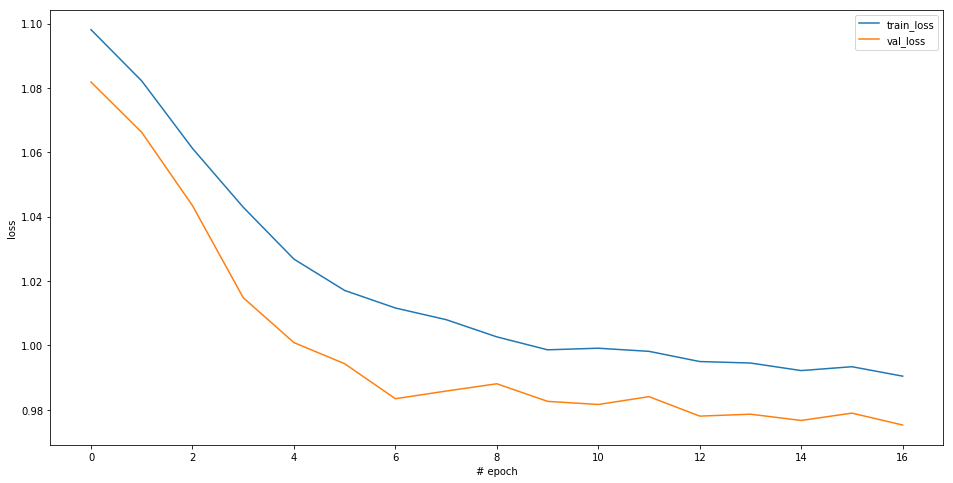

Train loss: 0.990
Val loss: 0.975



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

In [46]:
features = torch.from_numpy(df_train_features.values).type(torch.FloatTensor)
picks = torch.from_numpy(picks_dense).type(torch.FloatTensor)
targets = df_train_targets.next_roshan_team.map(make_roshan_target).values
targets = torch.from_numpy(targets).type(torch.LongTensor)
dataset = TensorDataset(features, picks, time_series, targets)
_, n_features = features.shape
_, n_heroes = picks.shape
*_, n_time_series_channels = time_series.shape
model = MultiInputPredictor(n_features, n_heroes, n_time_series_channels, n_classes=3)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
nn_cv_score = cross_val_score_nn(
    model, opt, dataset, train_batch_size=512, val_batch_size=512,
    scoring_function=f1_macro, loss_function=cross_entropy,
    callbacks=[BaseLogger(), BaseHistoryPlotter(), BasePrinter(), EarlyStopping(min_delta=0.025, patience=10)]
)

In [47]:
print('CV score: {:.3f}'.format(nn_cv_score.mean()))

CV score: 0.509
